In [276]:
import sys
sys.path.append("../lropy")

In [277]:
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import swifter
from pathlib import Path

In [278]:
from lropy.analysis.plotting import format_plot, save_plot
from lropy.constants import JULIAN_DAY
from lropy.analysis.spice_tools import as_et, as_utc, rotate_frame
from lropy.analysis.io import load_simulation_results
from lropy.analysis.transform import cart2track, cart2spher

In [279]:
def load_and_tf(folder):
    def tf(row):
        acc = row[["acc_rp_earth_x", "acc_rp_earth_y", "acc_rp_earth_z"]].to_numpy()
        pos = row[["pos_x", "pos_y", "pos_z"]].to_numpy()
        vel = row[["vel_x", "vel_y", "vel_z"]].to_numpy()

        row["acc_rp_earth_radial"], row["acc_rp_earth_along"], row["acc_rp_earth_cross"] = cart2track(acc, vel, pos)

        pos_spher = cart2spher(*(rotate_frame("ECLIPJ2000", "IAU_Earth", row["t_et"]) @ pos))
        row["lat"] = np.degrees(np.pi / 2 - pos_spher[1])
        row["lon"] = np.degrees(pos_spher[2])

        return row

    df = load_simulation_results(folder)
    return df.iloc[:, :].apply(tf, axis=1)

In [280]:
def plot_accelerations(dfs, labels, skip=[], scale_y=1):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10*scale_y), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    for df, label in zip(dfs, labels):
        if label in skip:
            continue
        ax_mag.plot(df.index, df["acc_rp_earth"], label=label)
        ax_radial.plot(df.index, df["acc_rp_earth_radial"])
        ax_along.plot(df.index, df["acc_rp_earth_along"])
        ax_cross.plot(df.index, df["acc_rp_earth_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

def plot_single(dfs, labels, column, title, skip=[], trim=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex="all")

    for df, label in zip(dfs, labels):
        if label in skip:
            continue
        if trim:
            df = df.iloc[:trim]
        ax.plot(df.index, df[column], label=label)

    ax.set_title(title)
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

def plot_magnitude(dfs, labels, skip=[], trim=None):
    plot_single(dfs, labels, "acc_rp_earth", "magnitude", skip, trim)

def plot_accelerations_joint(df, title, idx_start=0, ylim=[-1e-10, 4e-10]):
    fig, ax = plt.subplots(figsize=(8, 7), sharex="all")

    # Trim to one orbit
    df = df.iloc[idx_start:idx_start + 100]
    ax.plot(df.index, df["acc_rp_earth_radial"], label="radial")
    ax.plot(df.index, df["acc_rp_earth_along"], label="along")
    ax.plot(df.index, df["acc_rp_earth_cross"], label="cross")

    ax.legend()
    ax.set_title(title)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim(ylim)
    
    format_plot()

# Static vs dynamic paneling

## Constant distribution

In [281]:
# dynamic {6, 12} with constant albedo
df_const_dynamic_double_geomareas = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_double_geomareas")

In [282]:
# dynamic {6, 12} with constant albedo
df_const_dynamic_double = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_double")

In [283]:
# dynamic {12, 24, 36} with constant albedo
df_const_dynamic_hires = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_hires")

In [284]:
# dynamic {12, 24, 36} with constant albedo
df_const_dynamic_hires_geomareas = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_hires_geomareas")

In [285]:
# dynamic {12, 24, 36} with constant albedo
df_const_dynamic_superres = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_superres")

In [286]:
# dynamic {12, 24, 36} with constant albedo
df_const_dynamic_superres_geomareas = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_dynamic_superres_geomareas")

In [287]:
# static 100 with constant albedo
df_const_static_100 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_100")

In [288]:
# static 200 with constant albedo
df_const_static_200 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_200")

In [289]:
# static 2000 with constant albedo
df_const_static_2000 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/const_static_2000")

### Convergence of static paneling

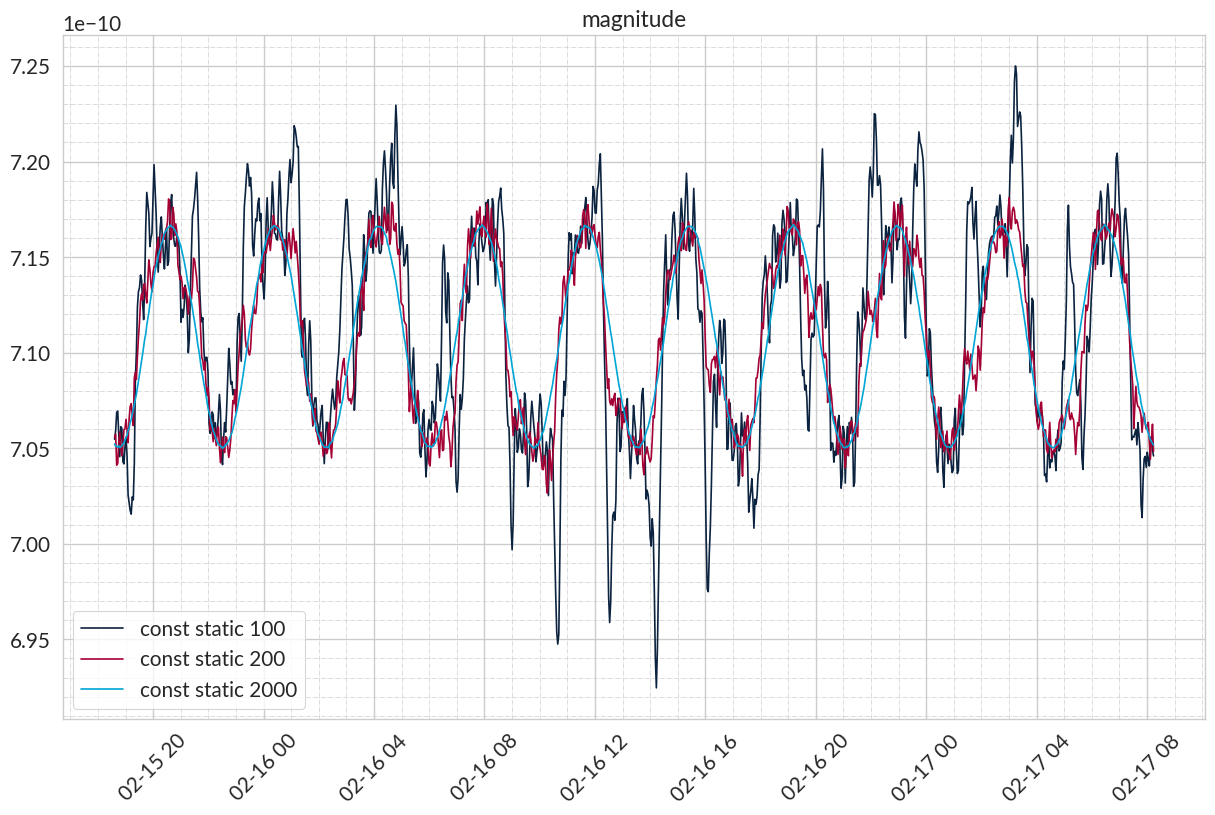

In [290]:
plot_magnitude(
    [df_const_static_100, df_const_static_200, df_const_static_2000],
    ["const static 100", "const static 200", "const static 2000"]
)

### Effect of different area calculation method

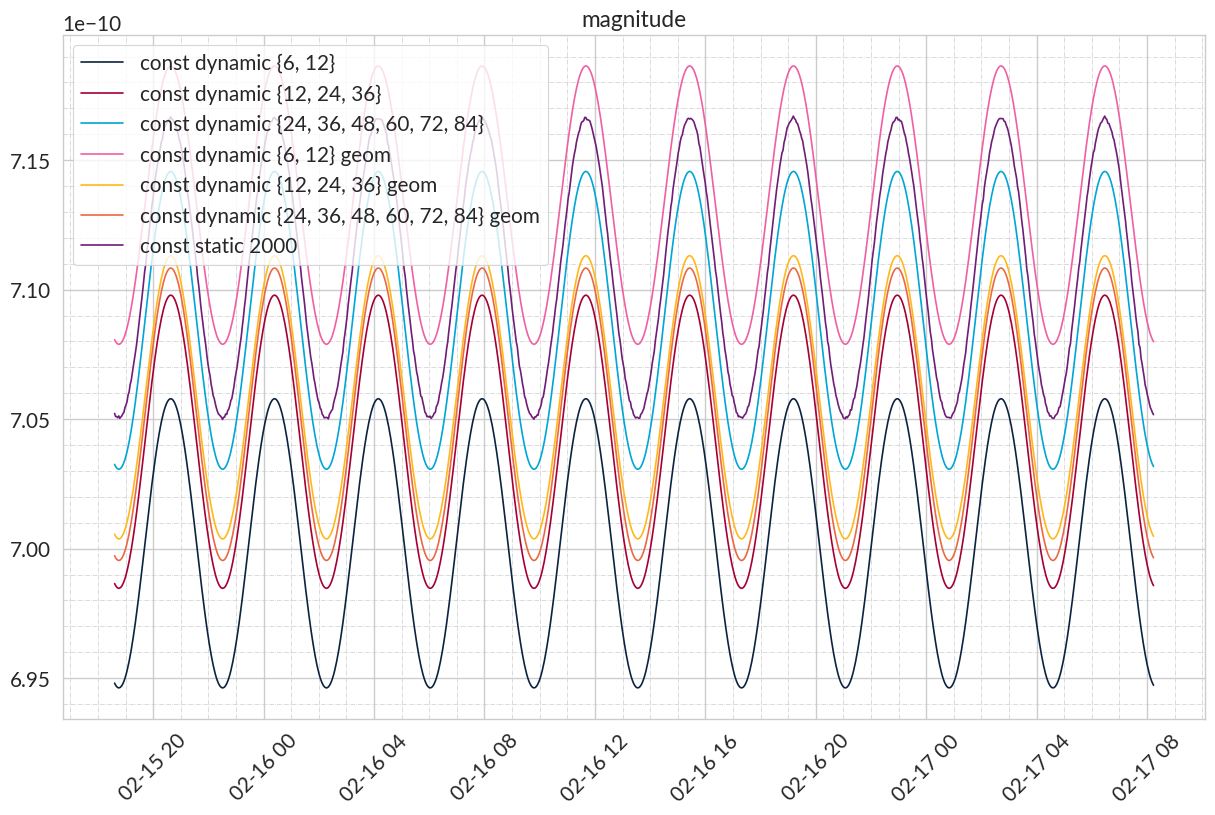

In [291]:
plot_magnitude(
    [df_const_dynamic_double, df_const_dynamic_hires, df_const_dynamic_superres, df_const_dynamic_double_geomareas, df_const_dynamic_hires_geomareas, df_const_dynamic_superres_geomareas, df_const_static_2000],
    ["const dynamic {6, 12}", "const dynamic {12, 24, 36}", "const dynamic {24, 36, 48, 60, 72, 84}", "const dynamic {6, 12} geom", "const dynamic {12, 24, 36} geom", "const dynamic {24, 36, 48, 60, 72, 84} geom", "const static 2000"]
)

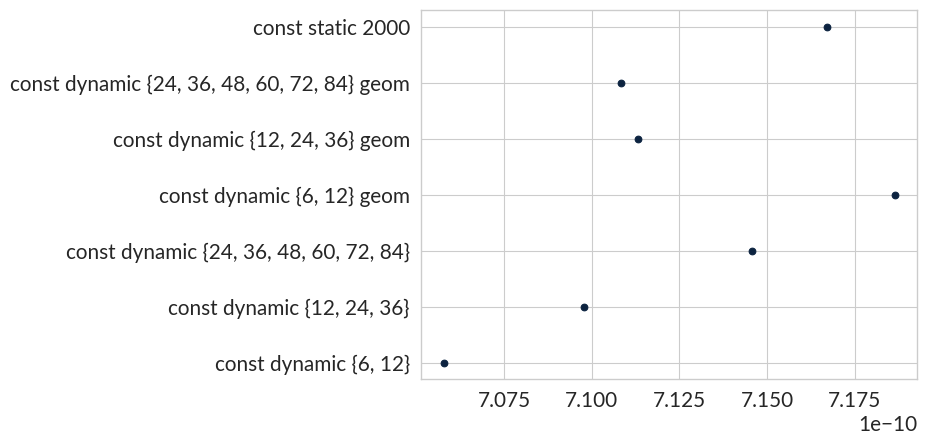

In [292]:
plt.scatter(
    np.max(np.vstack([df["acc_rp_earth"] for df in [df_const_dynamic_double, df_const_dynamic_hires, df_const_dynamic_superres, df_const_dynamic_double_geomareas, df_const_dynamic_hires_geomareas, df_const_dynamic_superres_geomareas, df_const_static_2000]]), axis=1),
    ["const dynamic {6, 12}", "const dynamic {12, 24, 36}", "const dynamic {24, 36, 48, 60, 72, 84}", "const dynamic {6, 12} geom", "const dynamic {12, 24, 36} geom", "const dynamic {24, 36, 48, 60, 72, 84} geom", "const static 2000"],
)

### Comparison of static and dynamic paneling accelerations

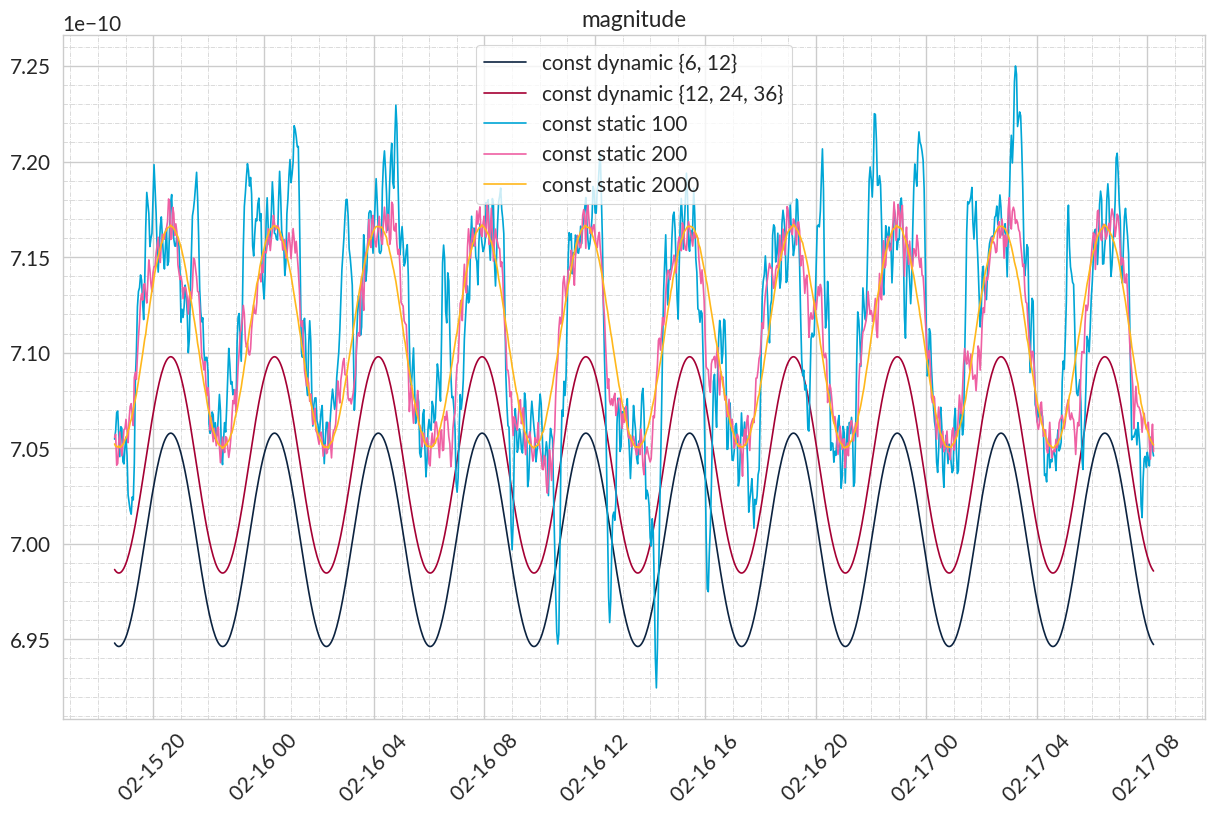

In [293]:
plot_magnitude(
    [df_const_dynamic_double, df_const_dynamic_hires, df_const_static_100, df_const_static_200, df_const_static_2000],
    ["const dynamic {6, 12}", "const dynamic {12, 24, 36}", "const static 100", "const static 200", "const static 2000"]
)

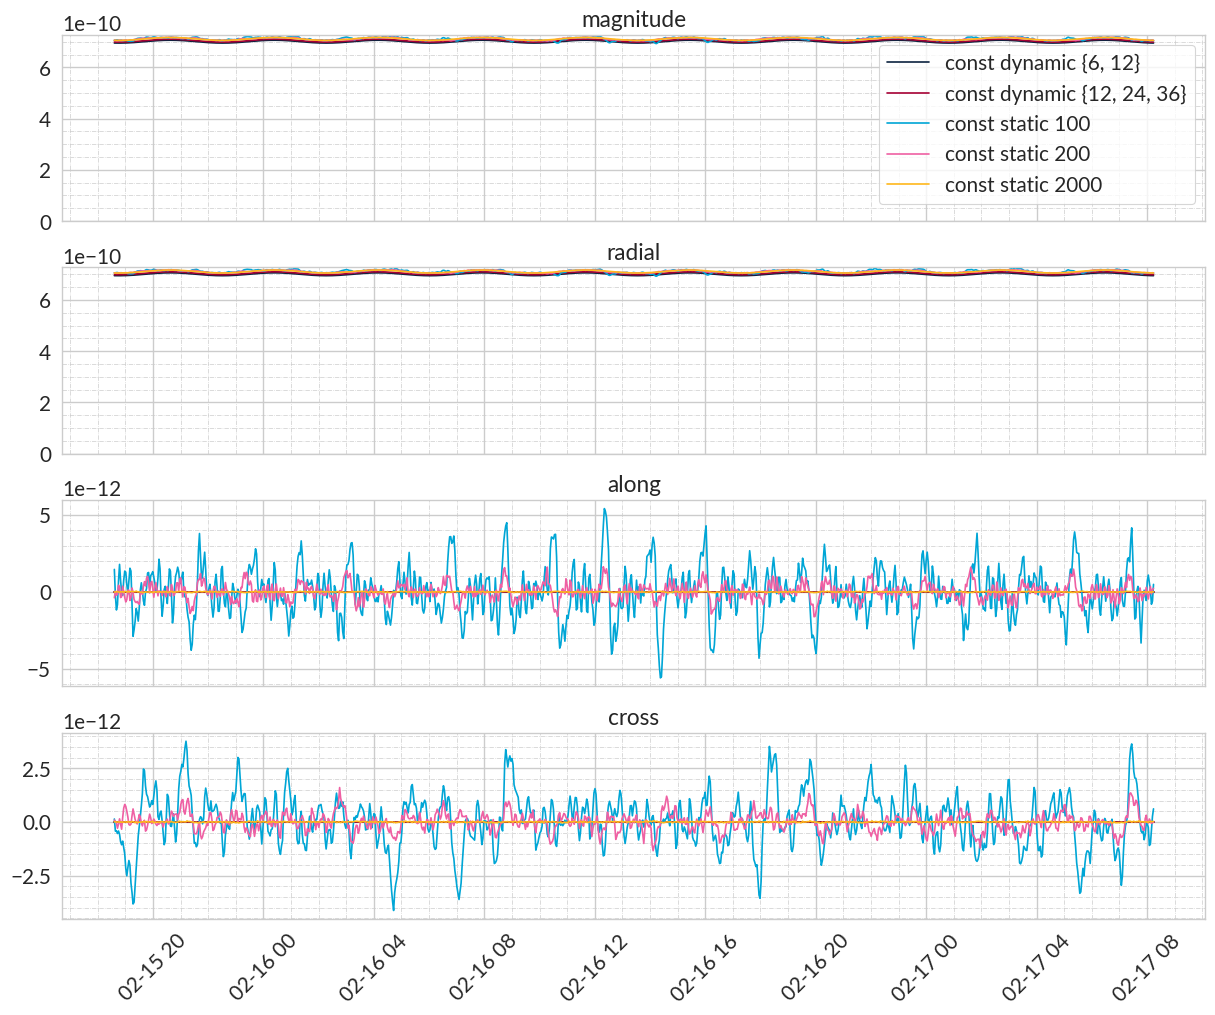

In [294]:
plot_accelerations(
    [df_const_dynamic_double, df_const_dynamic_hires, df_const_static_100, df_const_static_200, df_const_static_2000],
    ["const dynamic {6, 12}", "const dynamic {12, 24, 36}", "const static 100", "const static 200", "const static 2000"]
)

* Dynamic paneling approaches static paneling with more panels

# SH distribution

In [295]:
# static 2000 with SH albedo
df_sh_static_2000 = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_static_2000")

In [296]:
# dynamic {6, 12} with SH albedo
df_sh_dynamic_double = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_dynamic_double")

In [297]:
# dynamic {12, 24, 36} with SH albedo
df_sh_dynamic_hires = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_dynamic_hires")

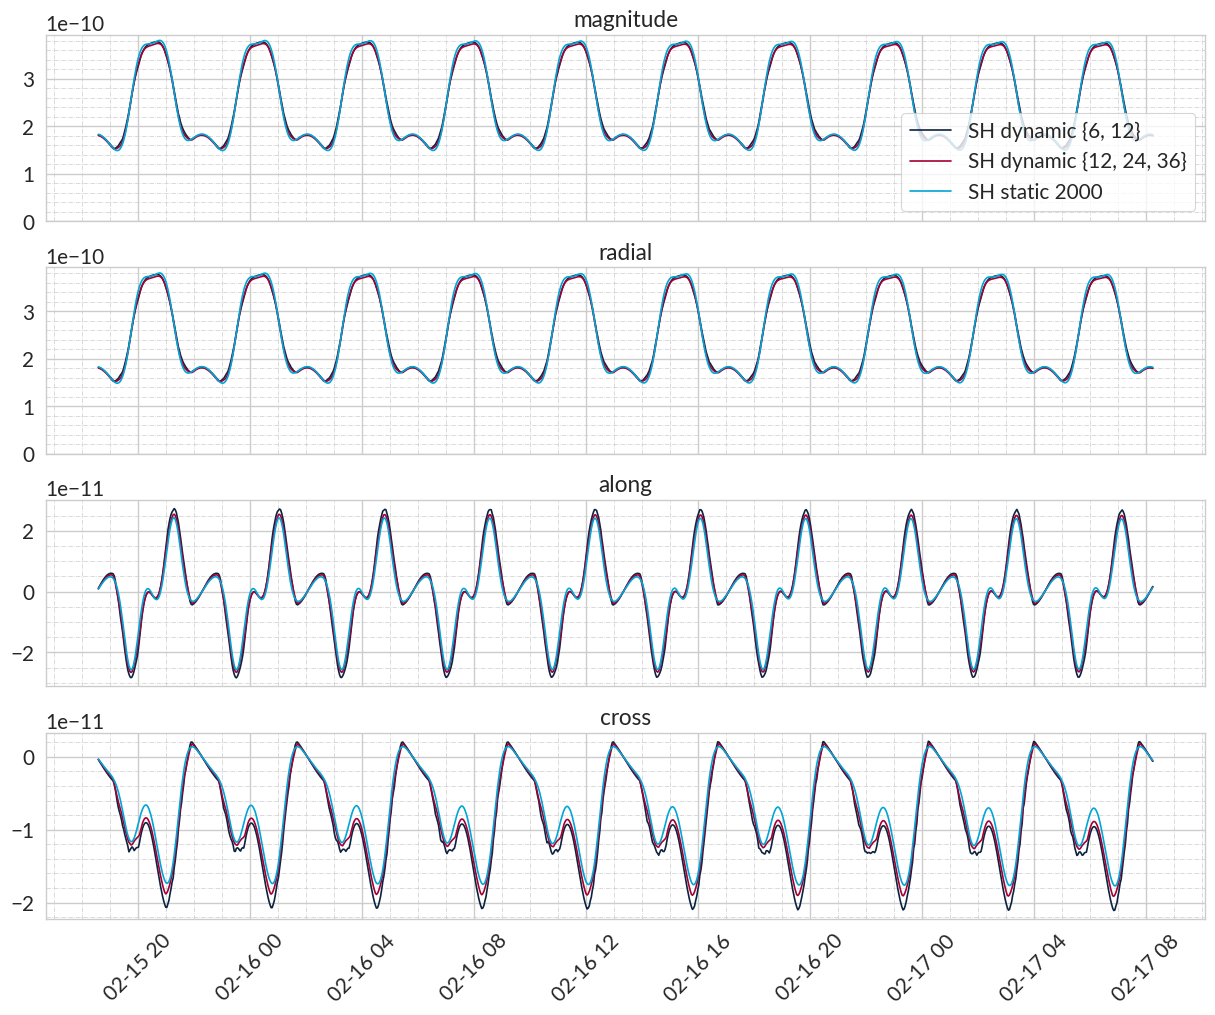

In [298]:
plot_accelerations(
    [df_sh_dynamic_double, df_sh_dynamic_hires, df_sh_static_2000],
    ["SH dynamic {6, 12}", "SH dynamic {12, 24, 36}", "SH static 2000"]
)

* Static paneling seems to be more stable, but this may just be this particular albedo distribution and orbit

## Convergence

In [299]:
dfs_convergence = {}
for f in Path("../../tudat-bundle/results/vv/convergence").glob("*"):
    dfs_convergence[int(f.name)] = load_and_tf(f)

dfs_convergence = dict(sorted(dfs_convergence.items(), key=lambda item: item[0]))

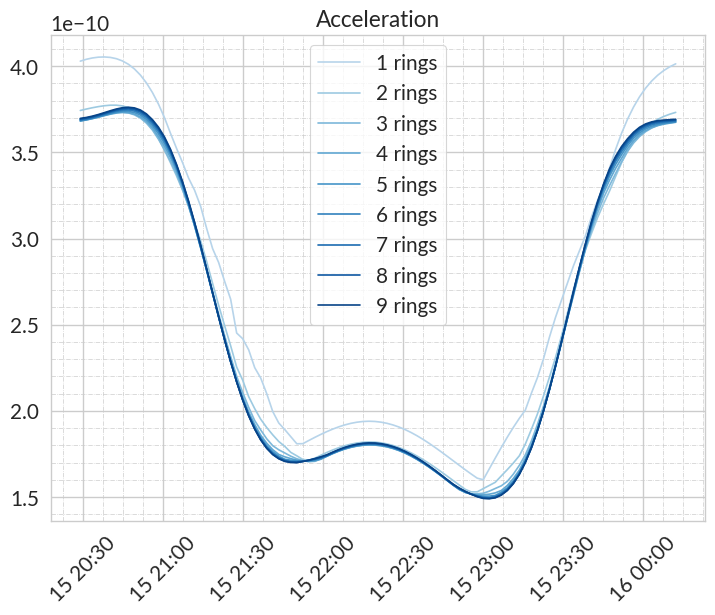

In [300]:
def plot_convergence_magnitude(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    idx_start = 50
    idx_end = idx_start + 100

    for df, label, color in zip(list(dfs)[:-1], list(labels)[:-1], cmap):
        df = df.iloc[idx_start:idx_end]
        ax.plot(df.index, df["acc_rp_earth"], label=f"{label} rings", c=color)

    ax.set_title("Acceleration")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())

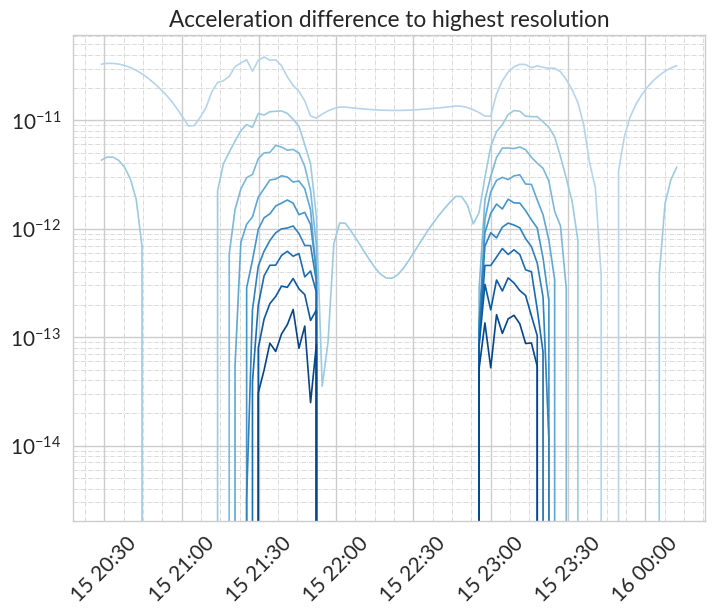

In [301]:
def plot_convergence_error(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    idx_start = 50
    idx_end = idx_start + 100

    df_ref = list(dfs)[-1]
    df_ref = df_ref.iloc[idx_start:idx_end]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(list(dfs)[:-1], list(labels)[:-1], cmap):
        df = df.iloc[idx_start:idx_end]
        ax.plot(df.index, df["acc_rp_earth"] - df_ref["acc_rp_earth"], label=f"{label} rings", c=color)

    ax.set_title("Acceleration difference to highest resolution")
    # ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())

# SH distribution (low orbit)

LAGEOS orbit around Earth but at altitude such that altitude/radius ratio matches LRO

In [302]:
# static 20000 with SH albedo in low orbit
df_sh_static_20000_low = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_static_20000_low")

In [303]:
# dynamic {6, 12} with SH albedo
df_sh_dynamic_double_low = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_dynamic_double_low")

In [304]:
# dynamic {12, 24, 36} with SH albedo in low orbit
df_sh_dynamic_hires_low = load_and_tf("../../tudat-bundle/results/static_vs_dynamic/sh_dynamic_hires_low")

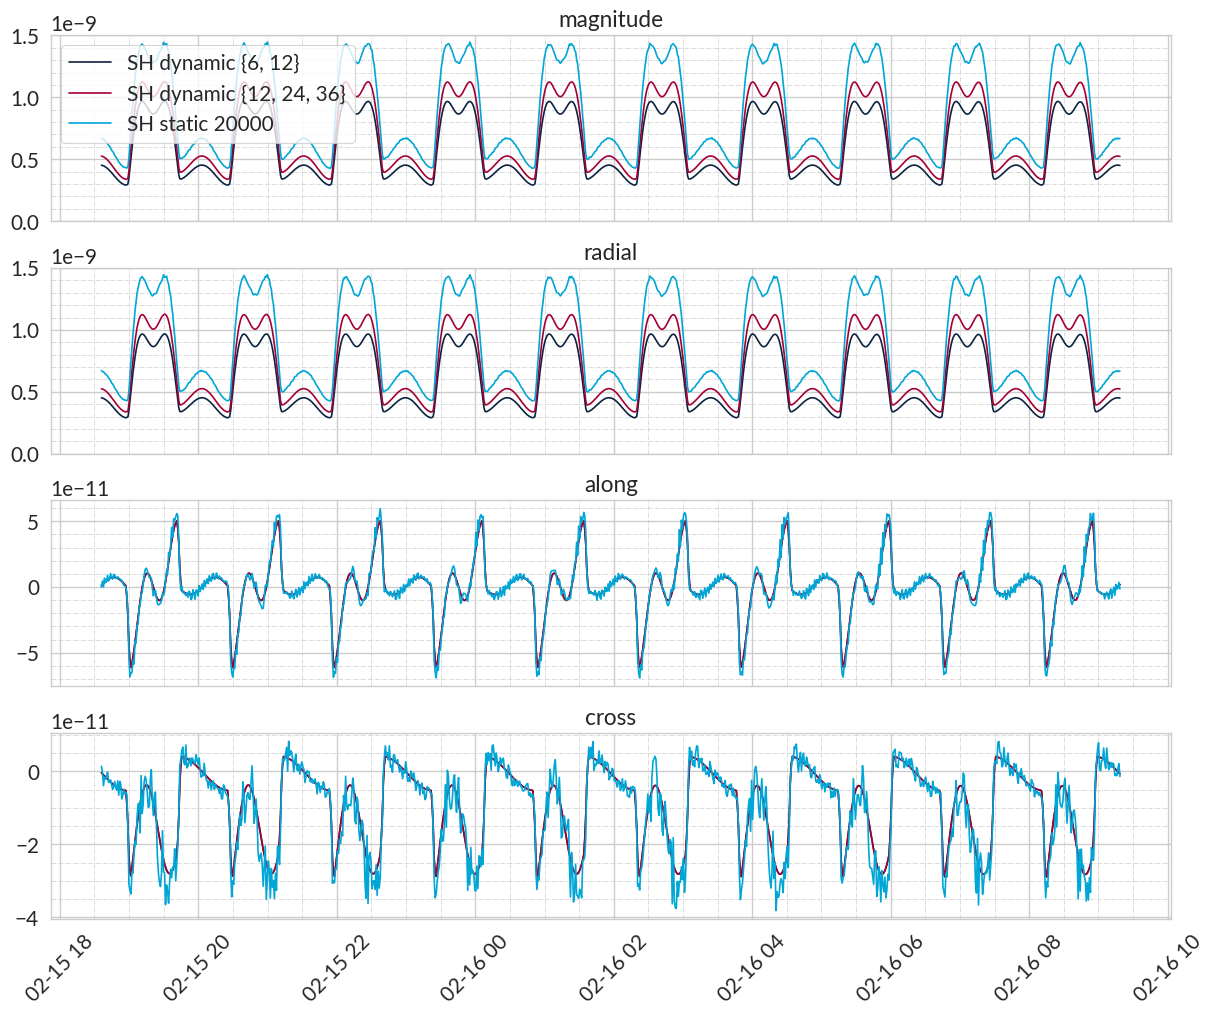

In [305]:
plot_accelerations(
    [df_sh_dynamic_double_low, df_sh_dynamic_hires_low, df_sh_static_20000_low],
    ["SH dynamic {6, 12}", "SH dynamic {12, 24, 36}", "SH static 20000"]
)

* Static paneling needs high number for low orbits

# tudat vs Orekit

In [306]:
# {24} with SH albedo
df_knocke_tudat_single = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_24")

In [307]:
# {6, 12} with SH albedo
df_knocke_tudat_double = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_6-12")

In [308]:
# {24, 24, 24} with SH albedo
df_knocke_tudat_triple = load_and_tf("../../tudat-bundle/results/vv/knocke_tudat_24-24-24")

In [309]:
def load_orekit(path):
    with open(f"{path}/data.txt") as f:
        rows = []
        for line in f.readlines():
            elems = line.split()
            date = elems[0]
            acc_radial = float(elems[1])
            acc_along = float(elems[2])
            acc_cross = float(elems[3])
            acc_mag = np.linalg.norm([acc_radial, acc_along, acc_cross])
            rows.append([date, acc_mag, acc_radial, acc_along, acc_cross])

    df = pd.DataFrame(rows, columns=["t", "acc_rp_earth", "acc_rp_earth_radial", "acc_rp_earth_along", "acc_rp_earth_cross"])
    df.index = pd.to_datetime(df["t"])

    return df

In [332]:
# 15 deg res with sin
df_knocke_orekit_15 = load_orekit("../results/vv/knocke_orekit_15")

In [311]:
# 15 deg res with cos
df_knocke_orekit_15_cos = load_orekit("../results/vv/knocke_orekit_15_cos")

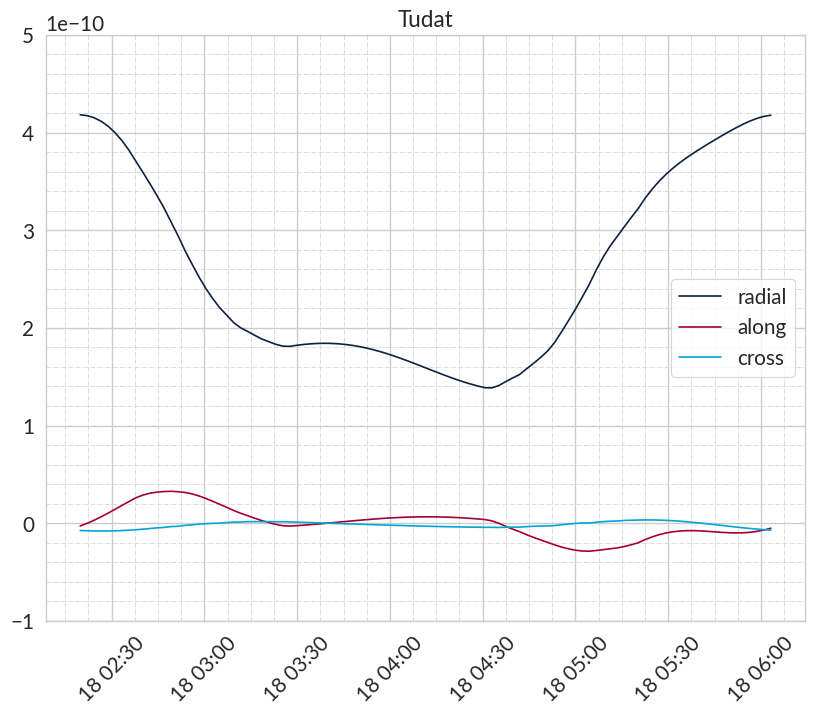

In [312]:
plot_accelerations_joint(df_knocke_tudat_double, "Tudat", ylim=[-1e-10, 5e-10], idx_start=62)

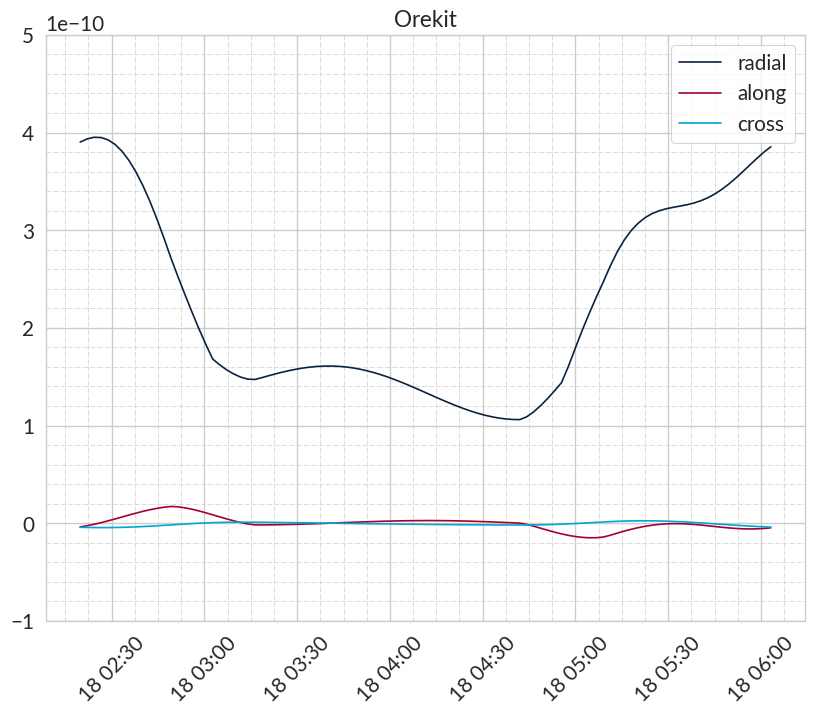

In [333]:
plot_accelerations_joint(df_knocke_orekit_15, "Orekit", ylim=[-1e-10, 5e-10], idx_start=62)

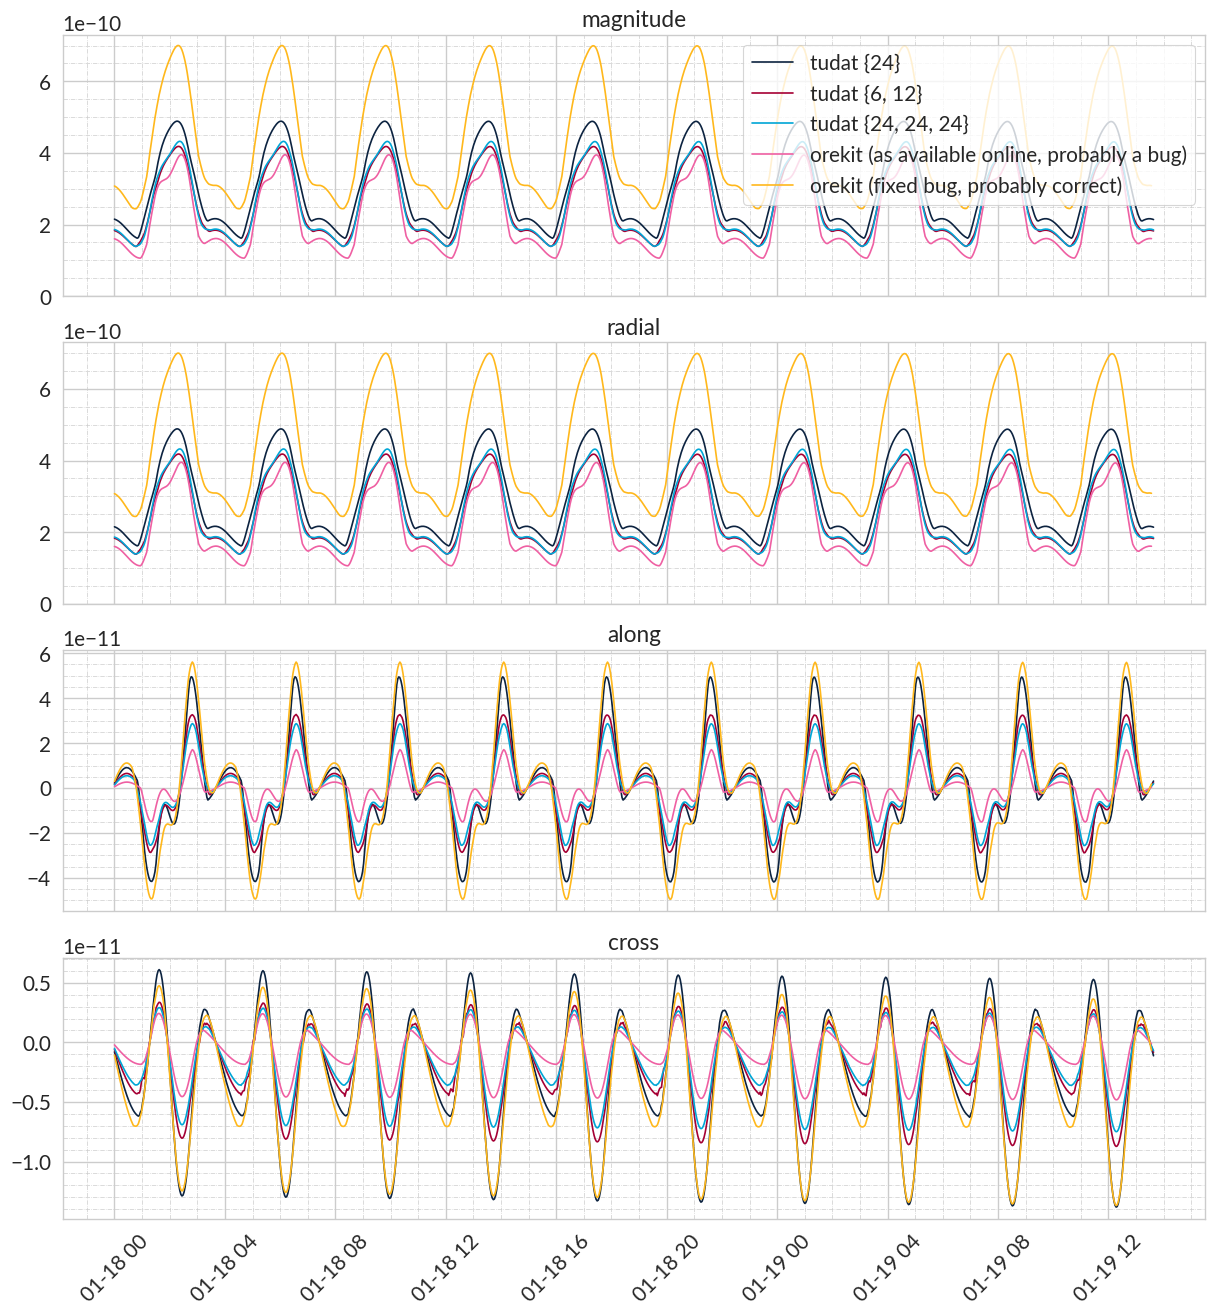

In [334]:
plot_accelerations(
    [df_knocke_tudat_single, df_knocke_tudat_double, df_knocke_tudat_triple, df_knocke_orekit_15, df_knocke_orekit_15_cos],
    ["tudat {24}", "tudat {6, 12}", "tudat {24, 24, 24}", "orekit (as available online, probably a bug)", "orekit (fixed bug, probably correct)"], scale_y=1.3)

Orekit uses an angular resolution of 15 deg -> {24} panels with sin bug, {24, 24, 24} with proper cos

* Summing the flux (single incident flux onto s/c instead of one from each panel) does not make any difference -> reduces computations, but will likely lead to incorrect results when used with a paneled target
* When the cos/sin bug is fixed (https://gitlab.orekit.org/orekit/orekit/-/issues/852) such that the entire spherical cap is filled with panels properly (with sin, the used cap is smaller than the actual visible cap), the magnitude doubles
* Neither of the cos/sin versions agrees well with the tudat results, but the order of magnitude agrees
* Phasing of the cross acceleration is off

Differences between computations in orekit and tudat:
* Orekit uses single summed flux, while we apply fluxes from each panel individually
* Orekit uses an angular resolution instead of a fixed number of panels -> a higher orbit results in more panels, which is not how Knocke did it
* Orekit uses the same angular resolution for zonal and meriodinal flow -> same number of panels per ring

# Find date

LAGEOS orbit for different orbits to find the one corresponding to Knocke's paper

In [315]:
def load_dates(dates, suffix=None):
    dfs = {}
    for date in dates:
        folder = date if suffix is None else f"{date}{suffix}"
        path = Path("../../tudat-bundle/results/vv/finddate/") / folder
        dfs[date] = load_and_tf(path)

    for df in dfs.values():
        df.index = list(dfs.values())[0].index

    dfs = dict(sorted(dfs.items(), key=lambda item: item[0]))
    return dfs

In [316]:
dfs_0deg = load_dates([
    "1977-02-20",
    "1977-02-21",
    "1977-02-22",
    "1977-02-23",
    "1977-02-24",
    "1977-02-25",
])

In [317]:
dfs_0deg2 = load_dates([
    # "1977-02-22",
    # "1977-02-25",
    # "1977-02-28",
    "1977-03-03",
    "1977-03-06",
    # "1977-03-09",
    # "1977-03-12",
    # "1977-03-15",
])

In [318]:
dfs_0deg3 = load_dates([
    # "1977-08-22",
    "1977-08-25",
    "1977-08-28",
    "1977-08-31",
    "1977-09-03",
    "1977-09-06",
    "1977-09-09",
    # "1977-09-12",
    # "1977-09-15",
])

In [319]:
dfs_aprime = load_dates([
    "1977-04-22",
    "1977-02-22",
    "1977-03-03",
    "1977-08-25",
    "1977-08-31"
], suffix="_aprime")

In [320]:
dfs_year = load_dates([
    "1977-01-22",
    "1977-02-22",
    "1977-03-22",
    "1977-04-22",
    "1977-05-22",
    "1977-06-22",
    "1977-07-22",
    "1977-08-22",
    "1977-09-22",
    "1977-10-22",
    "1977-11-22",
    "1977-12-22",
])

In [321]:
dfs_years = load_dates([
    "1977-01-22",
    "1977-02-22",
    "1977-03-22",
    "1977-04-22",
    "1977-05-22",
    "1977-06-22",
    "1977-07-22",
    "1977-08-22",
    "1977-09-22",
    "1977-10-22",
    "1977-11-22",
    "1977-12-22",
    "1978-01-22",
    "1978-02-22",
    "1978-03-22",
    "1978-04-22",
    "1978-05-22",
    "1978-06-22",
    "1978-07-22",
    "1978-08-22",
    "1978-09-22",
    "1978-10-22",
    "1978-11-22",
    "1978-12-22",
    "1979-01-22",
    "1979-02-22",
    "1979-03-22",
    "1979-04-22",
    "1979-05-22",
    "1979-06-22",
    "1979-07-22",
    "1979-08-22",
    "1979-09-22",
    "1979-10-22",
    "1979-11-22",
    "1979-12-22",
])

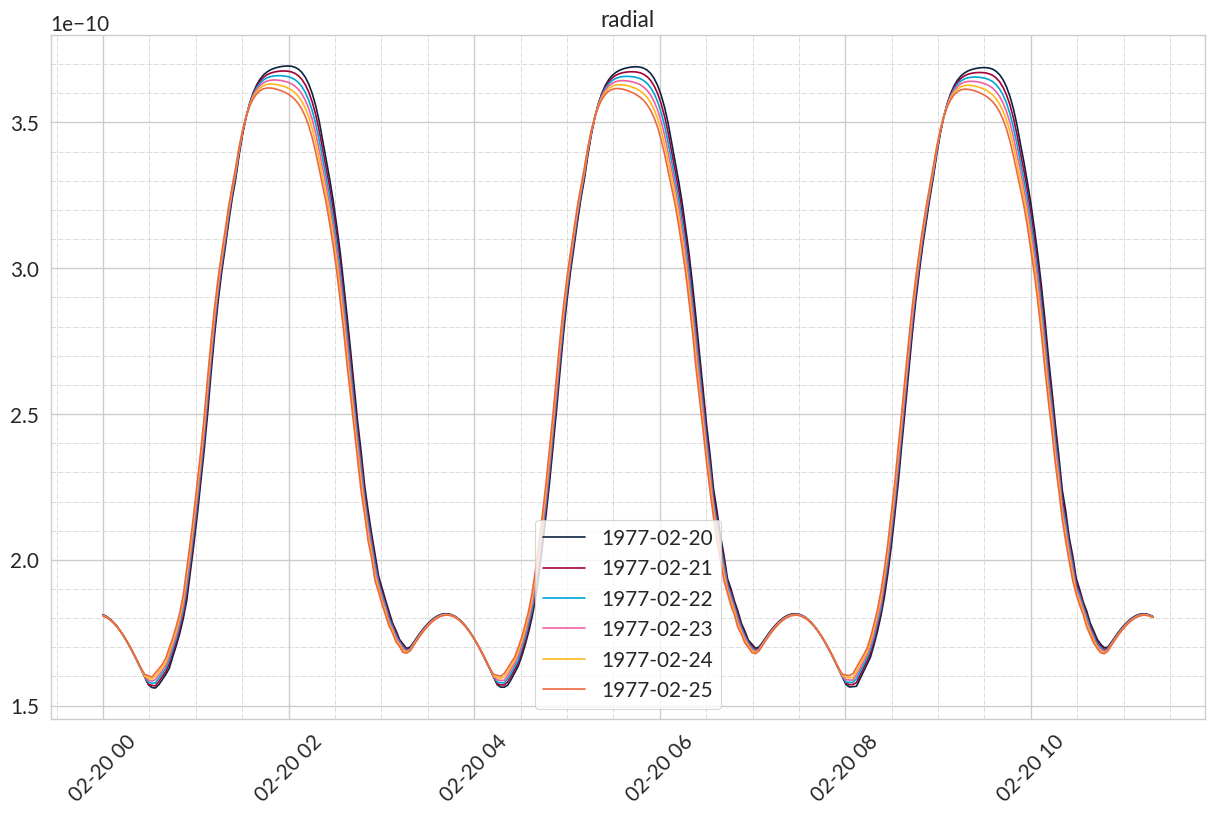

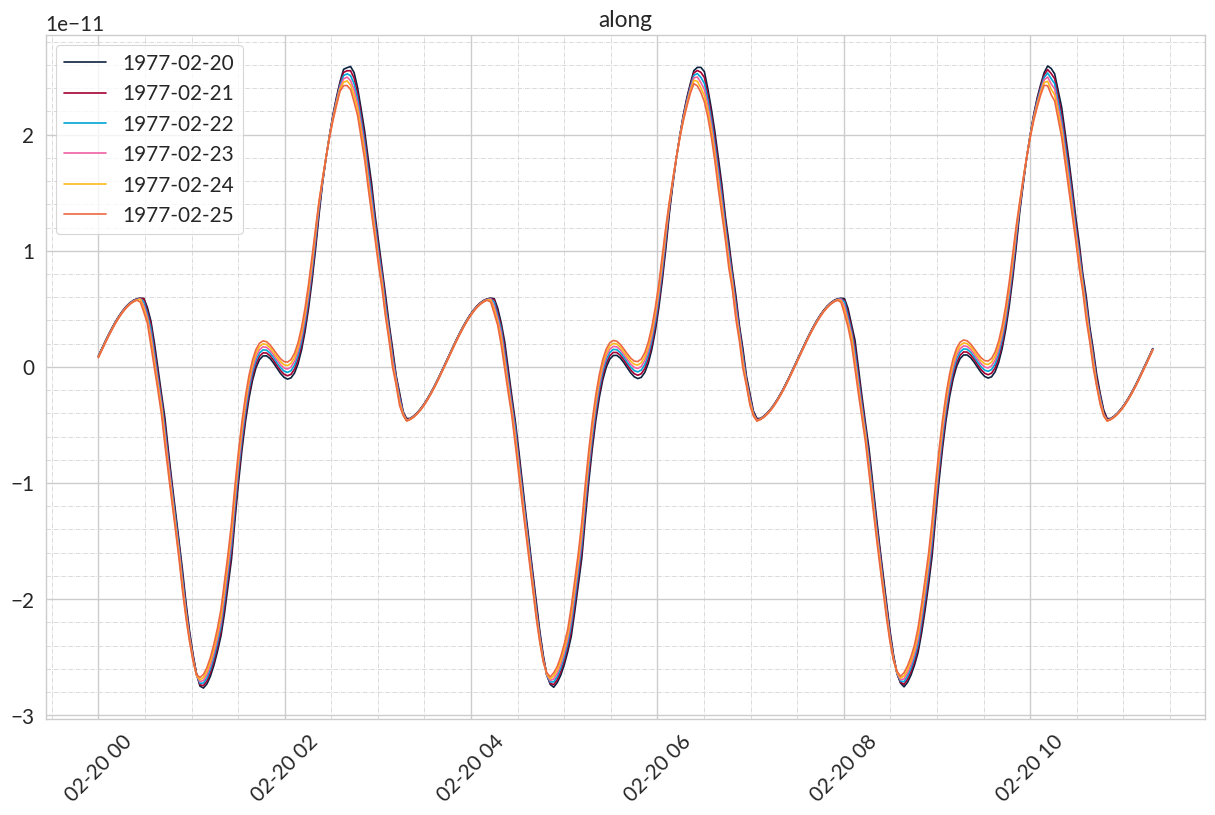

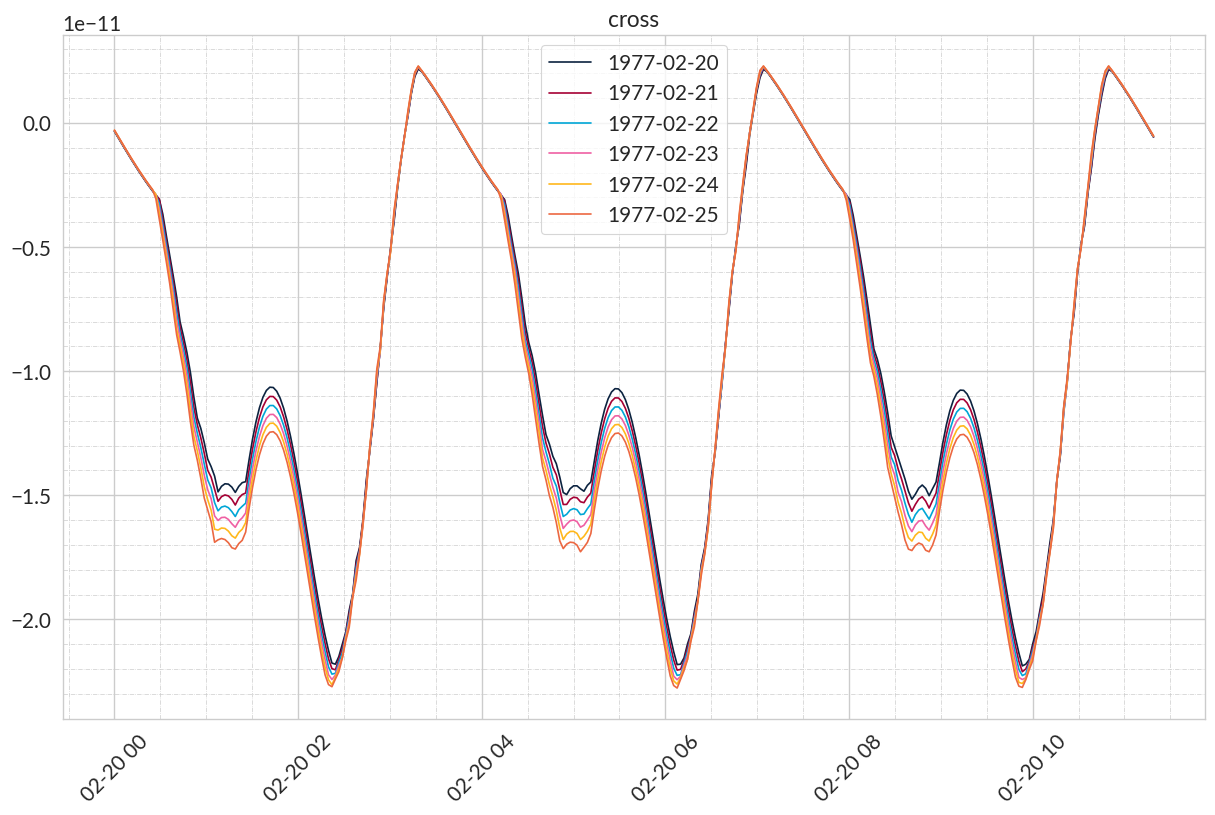

In [322]:
plot_single(dfs_0deg.values(), dfs_0deg.keys(), "acc_rp_earth_radial", "radial")
plot_single(dfs_0deg.values(), dfs_0deg.keys(), "acc_rp_earth_along", "along")
plot_single(dfs_0deg.values(), dfs_0deg.keys(), "acc_rp_earth_cross", "cross")

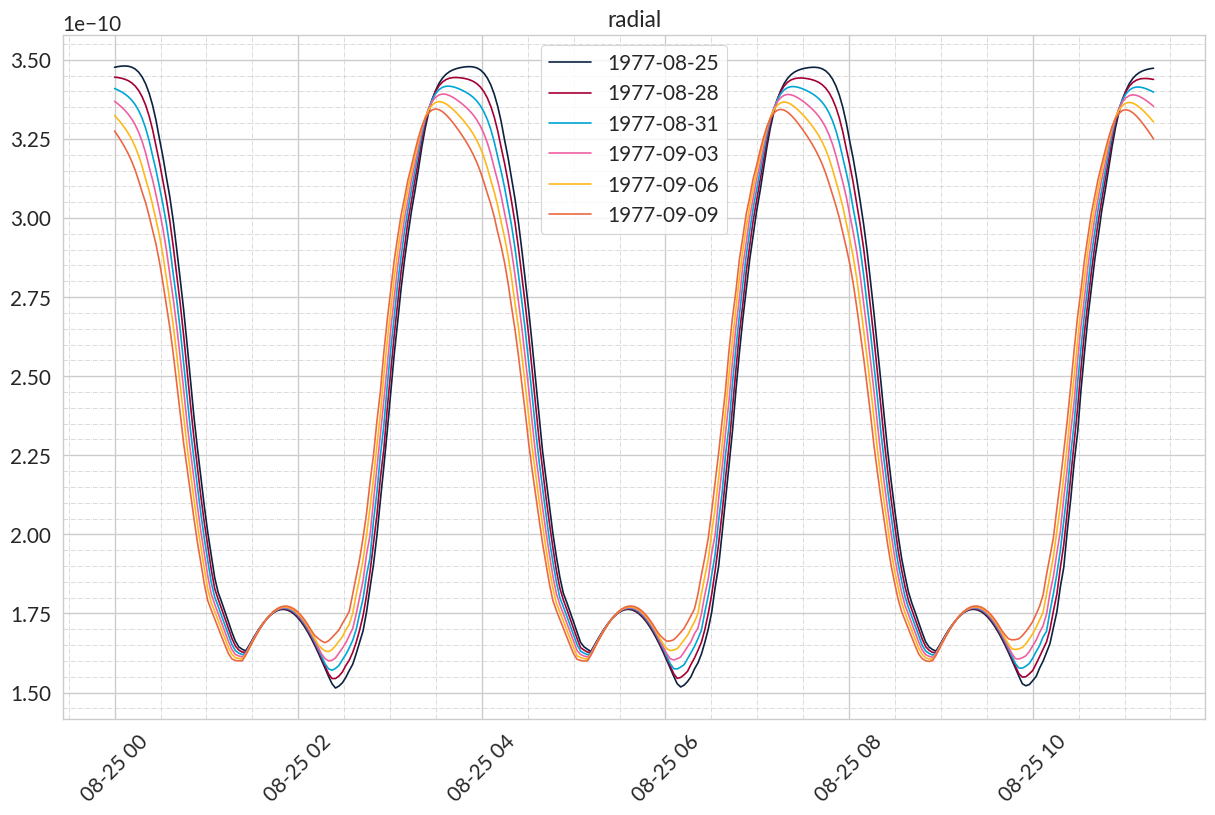

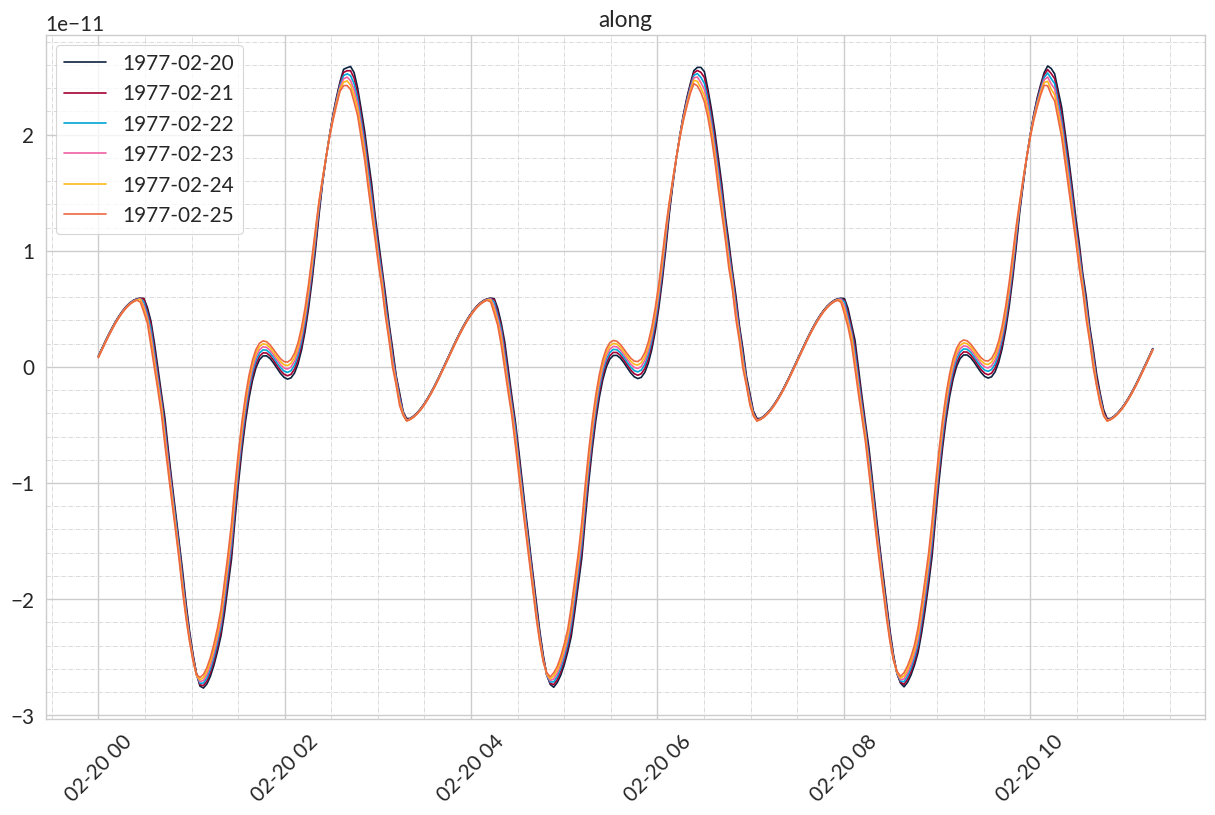

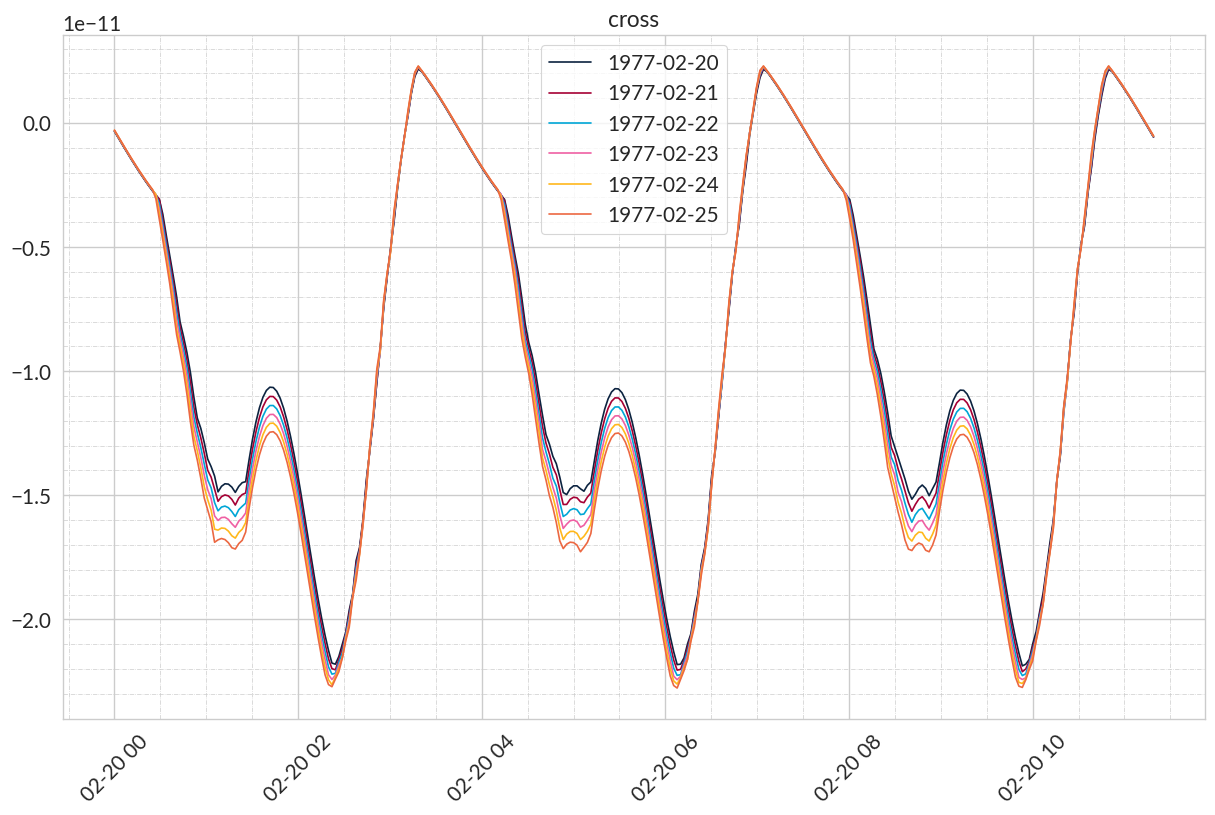

In [323]:
plot_single(dfs_0deg3.values(), dfs_0deg3.keys(), "acc_rp_earth_radial", "radial")
plot_single(dfs_0deg.values(), dfs_0deg.keys(), "acc_rp_earth_along", "along")
plot_single(dfs_0deg.values(), dfs_0deg.keys(), "acc_rp_earth_cross", "cross")

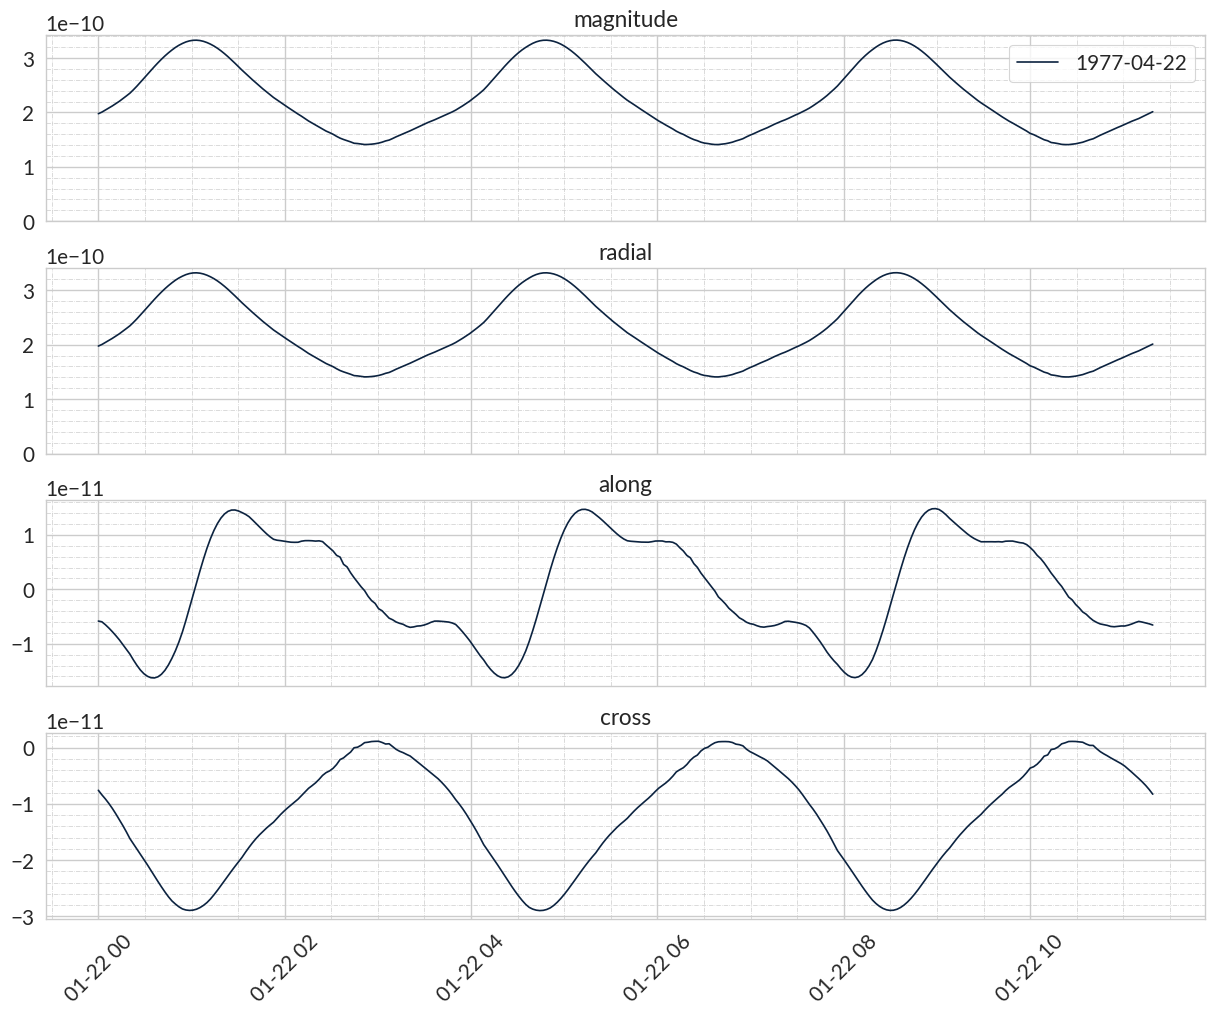

In [324]:
plot_accelerations([dfs_year["1977-04-22"]], ["1977-04-22"])

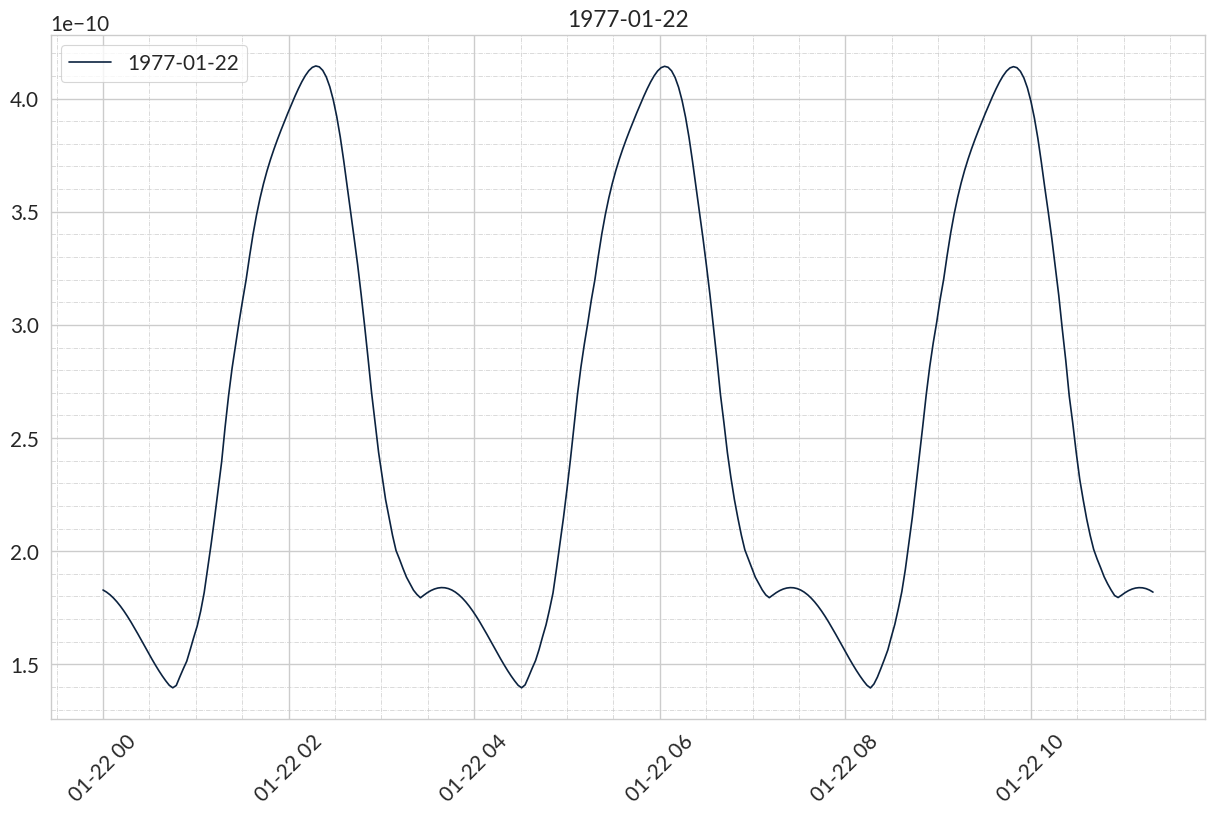

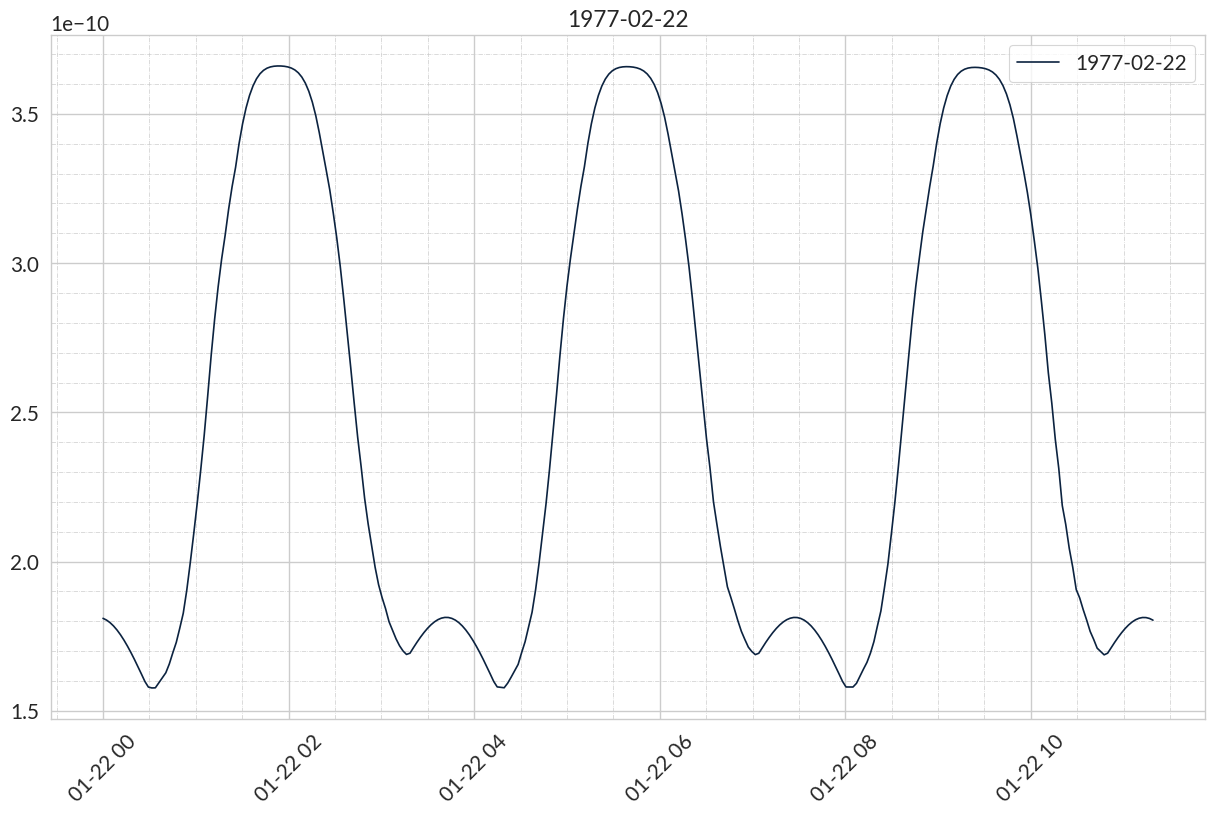

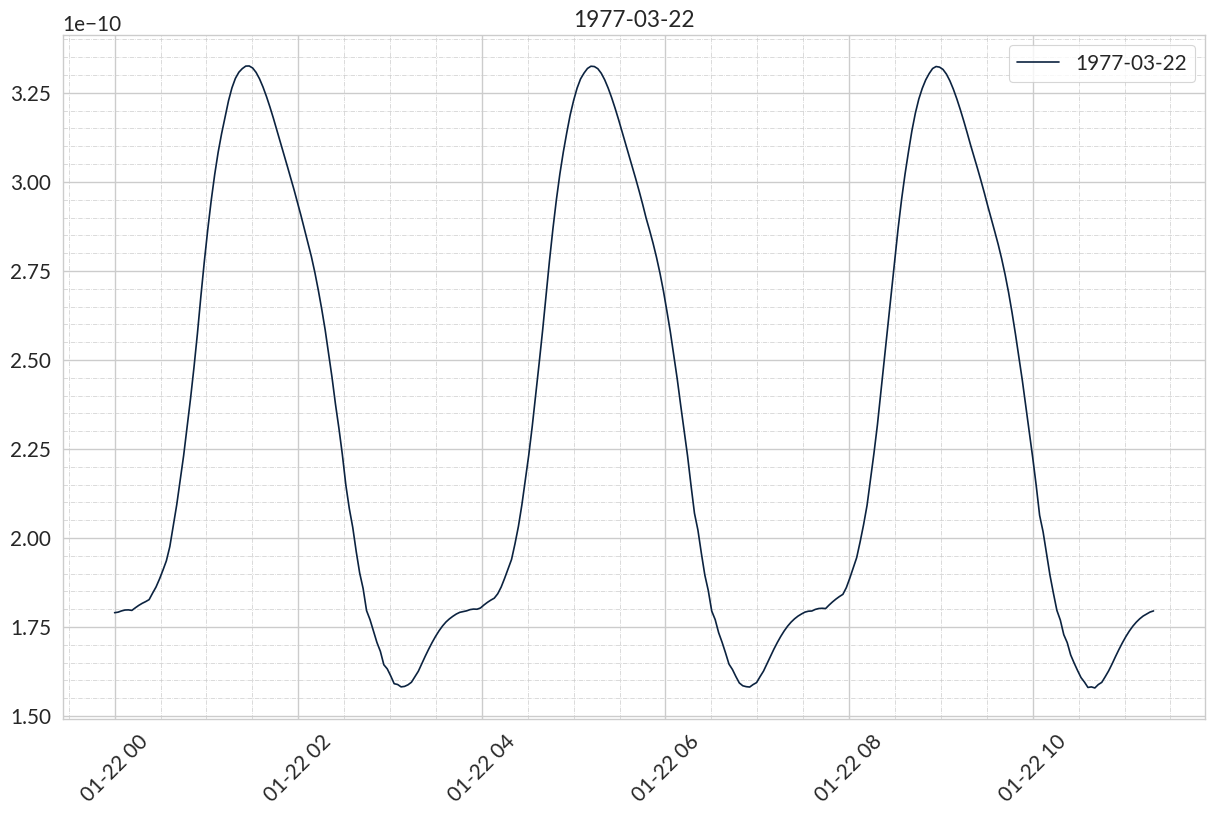

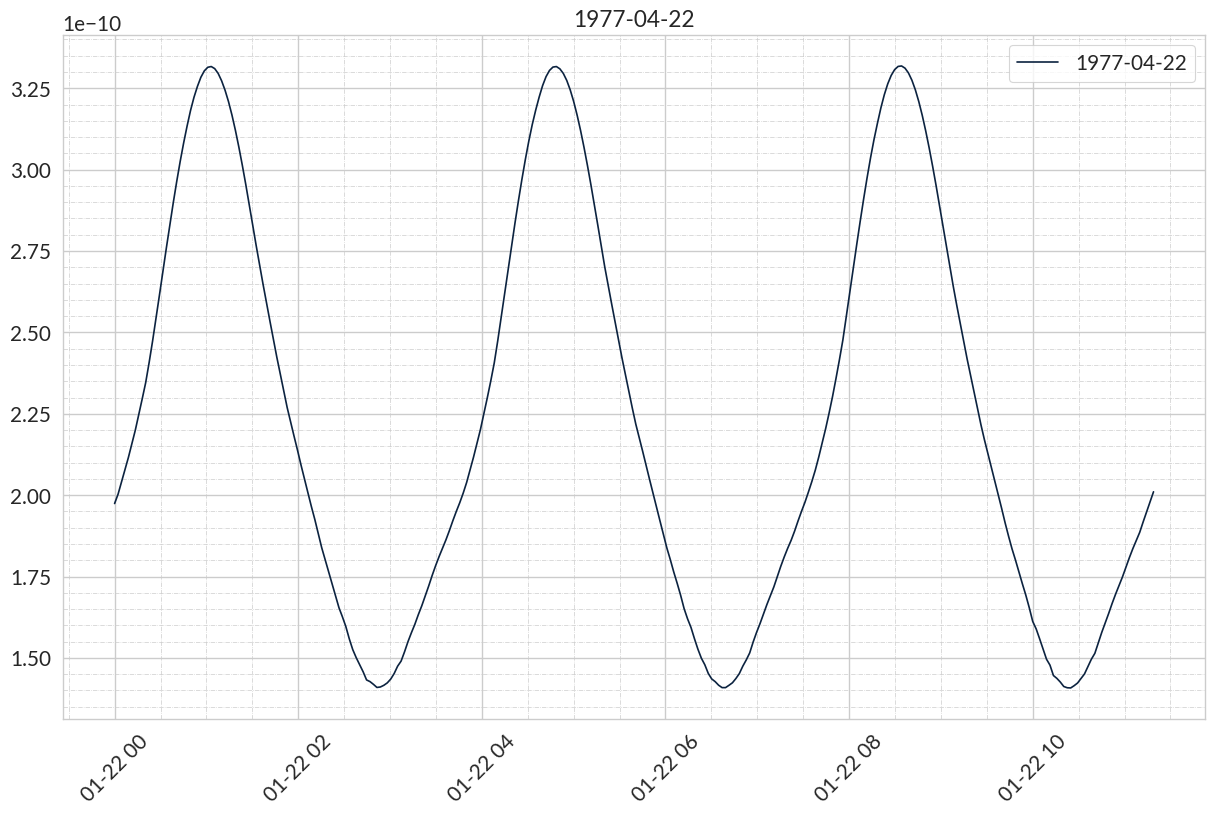

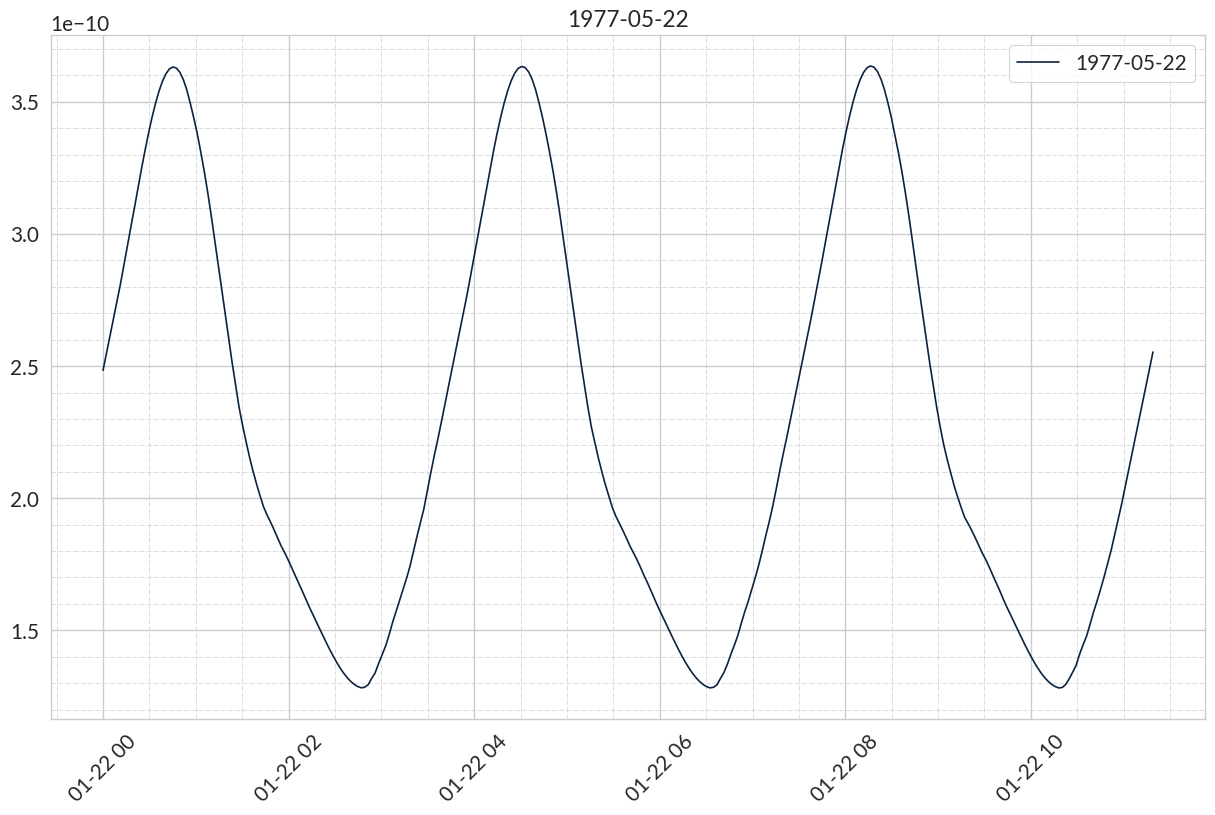

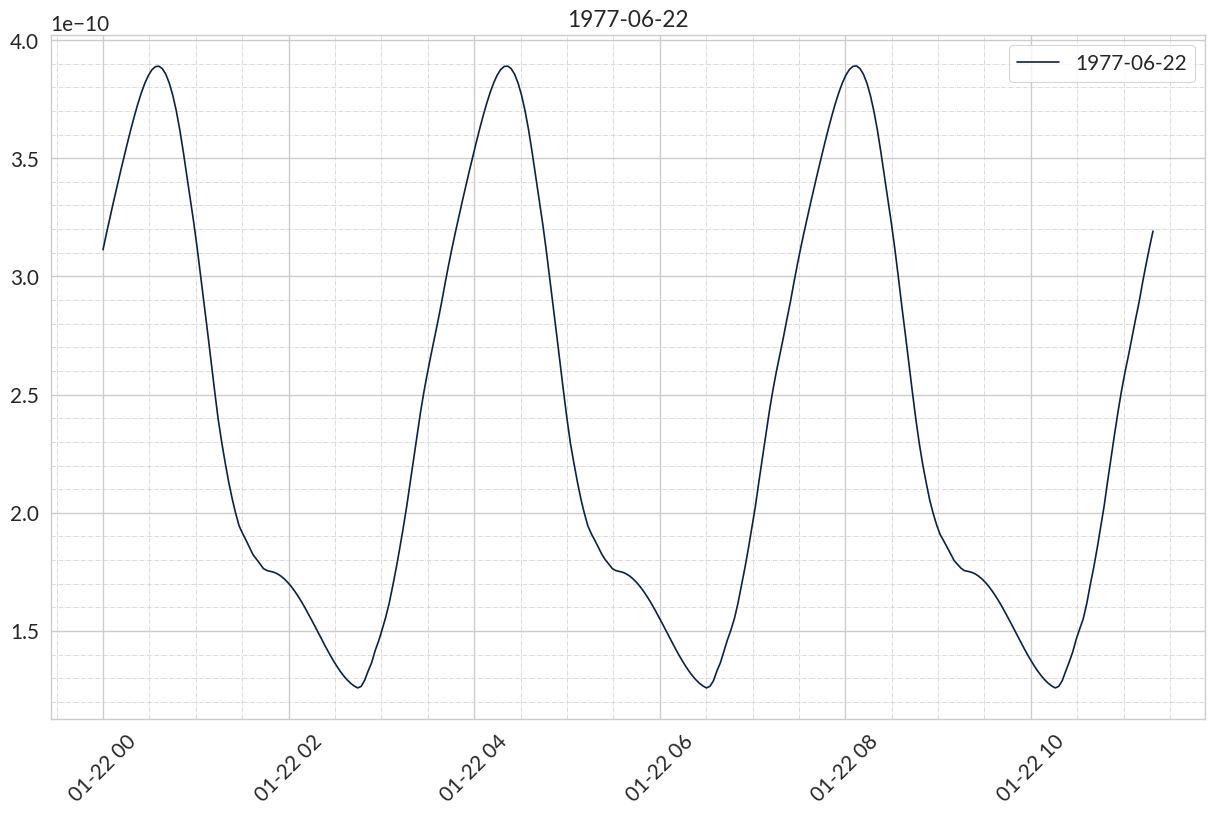

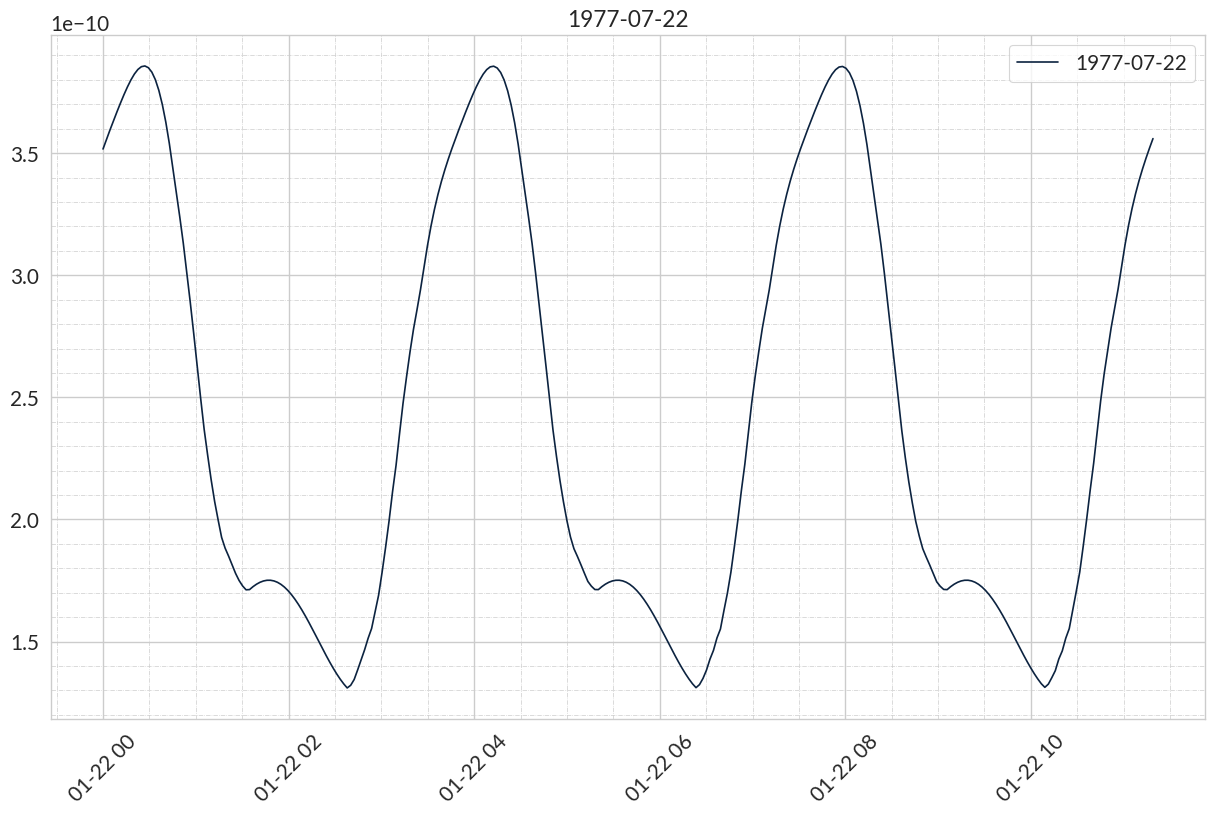

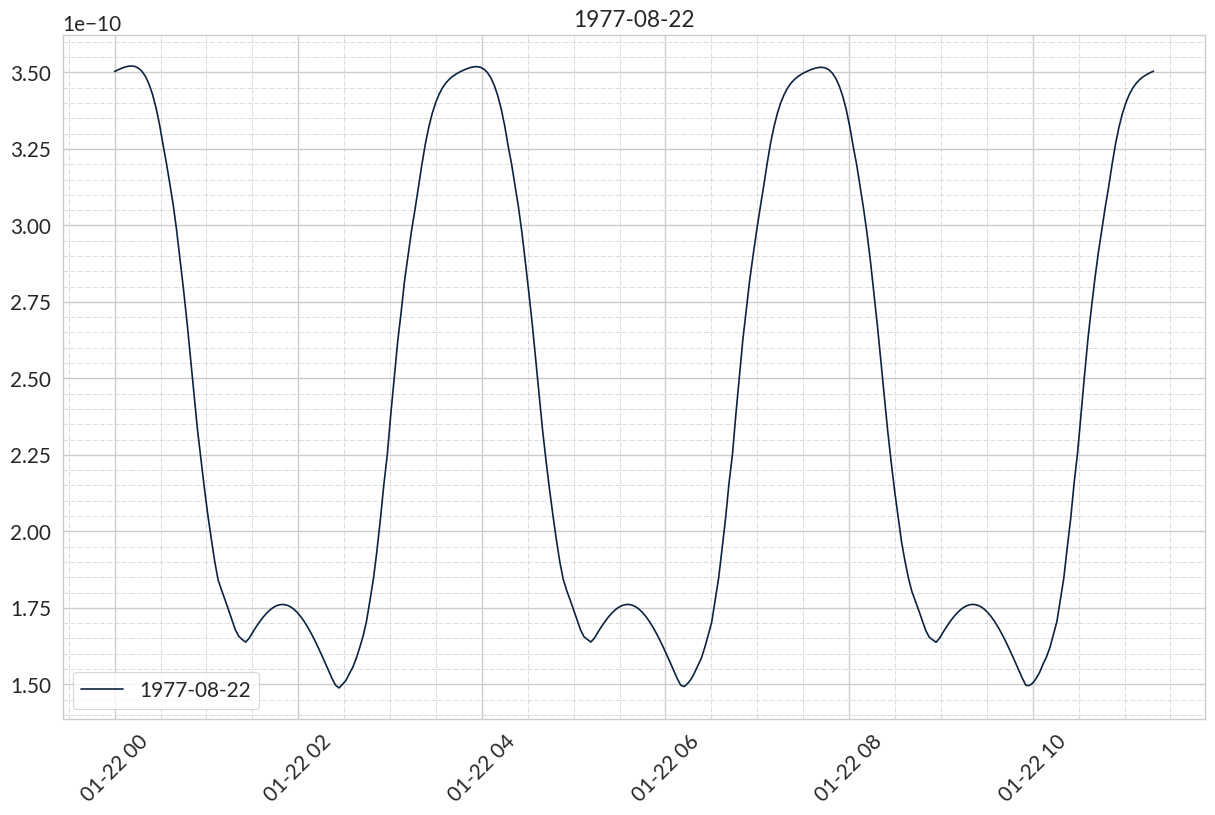

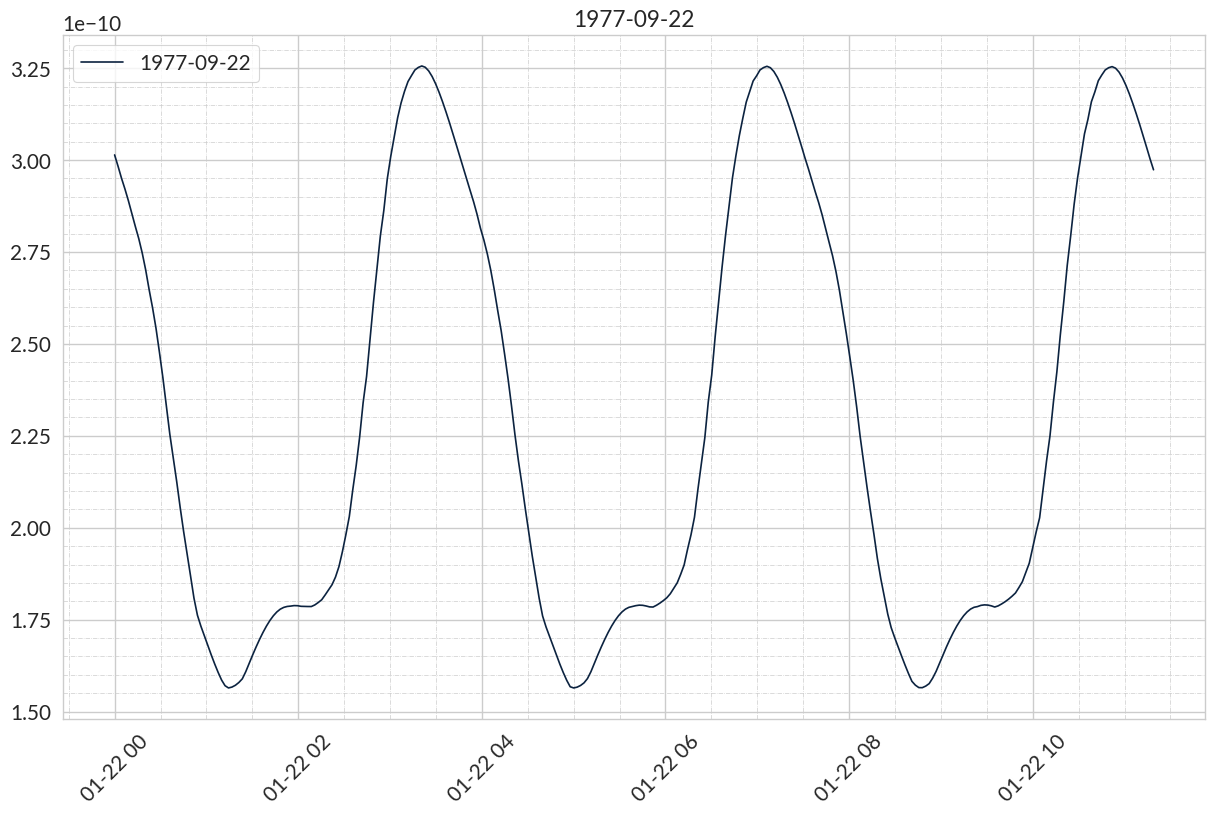

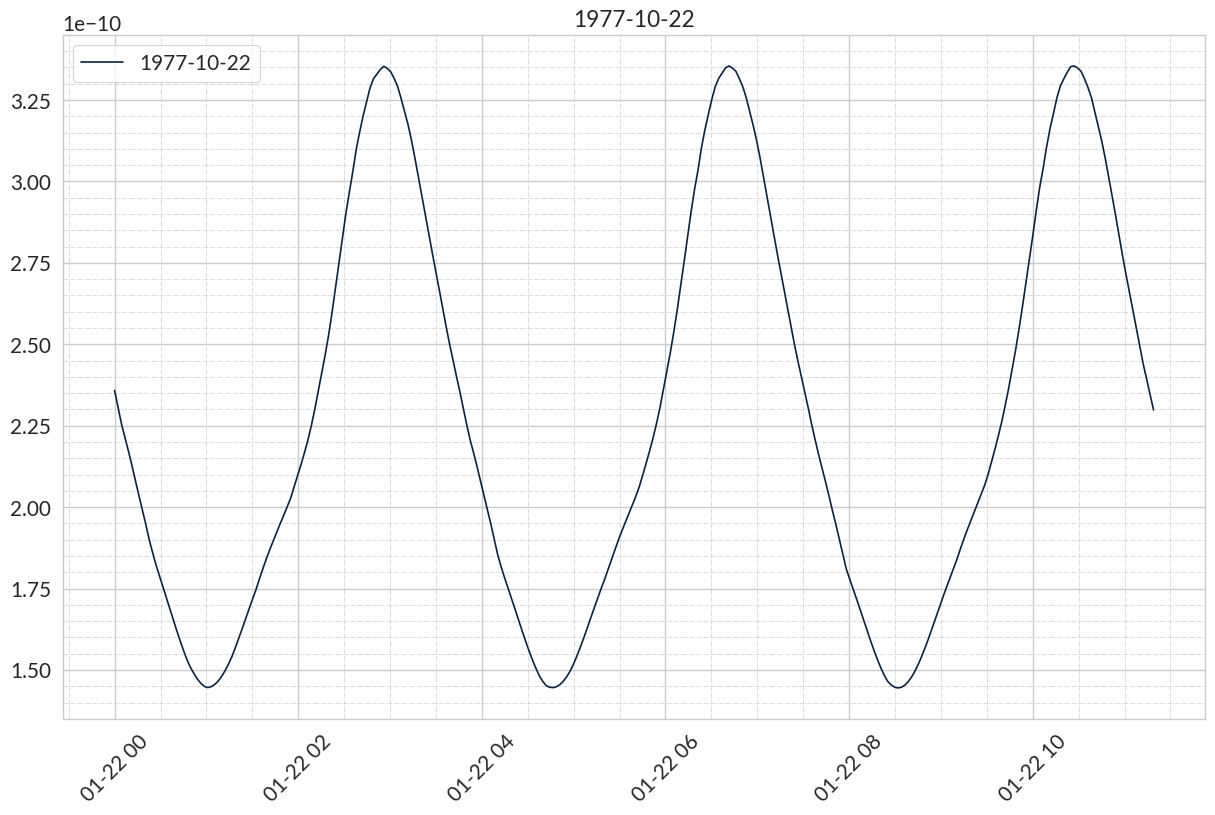

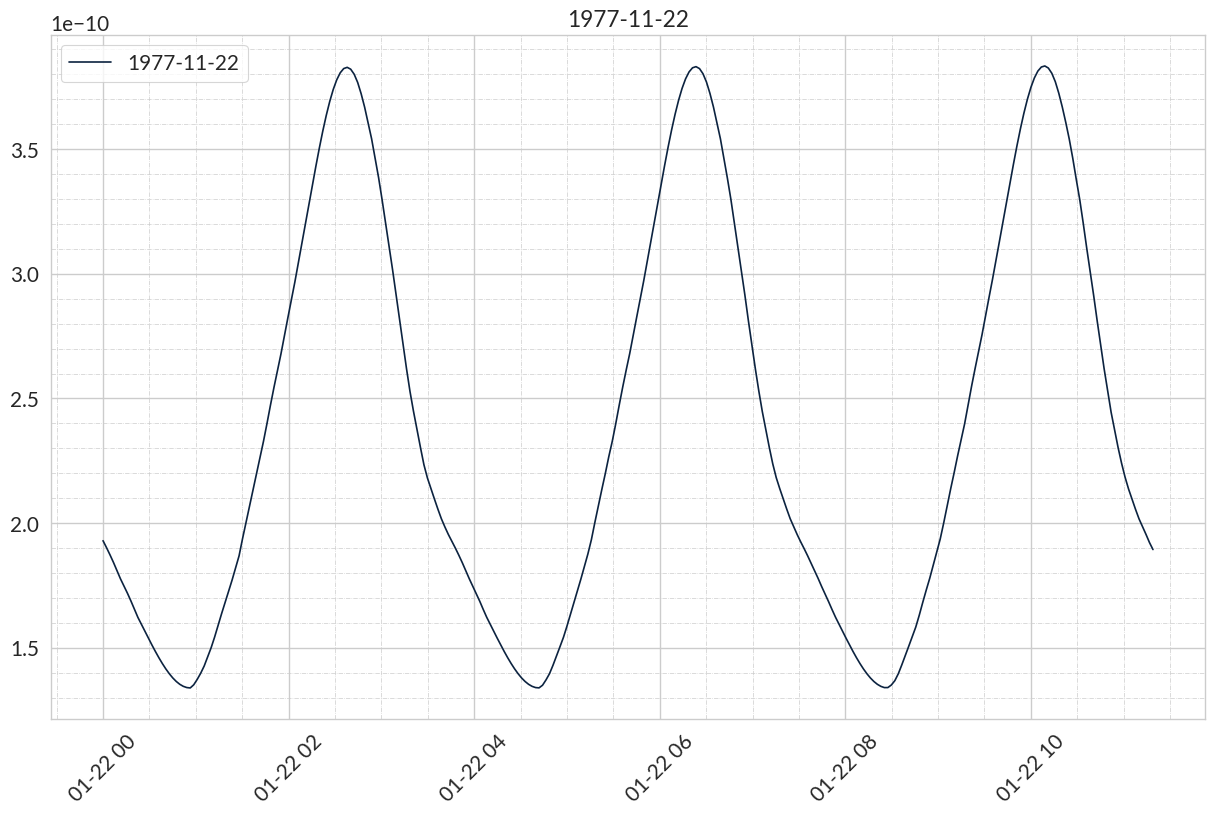

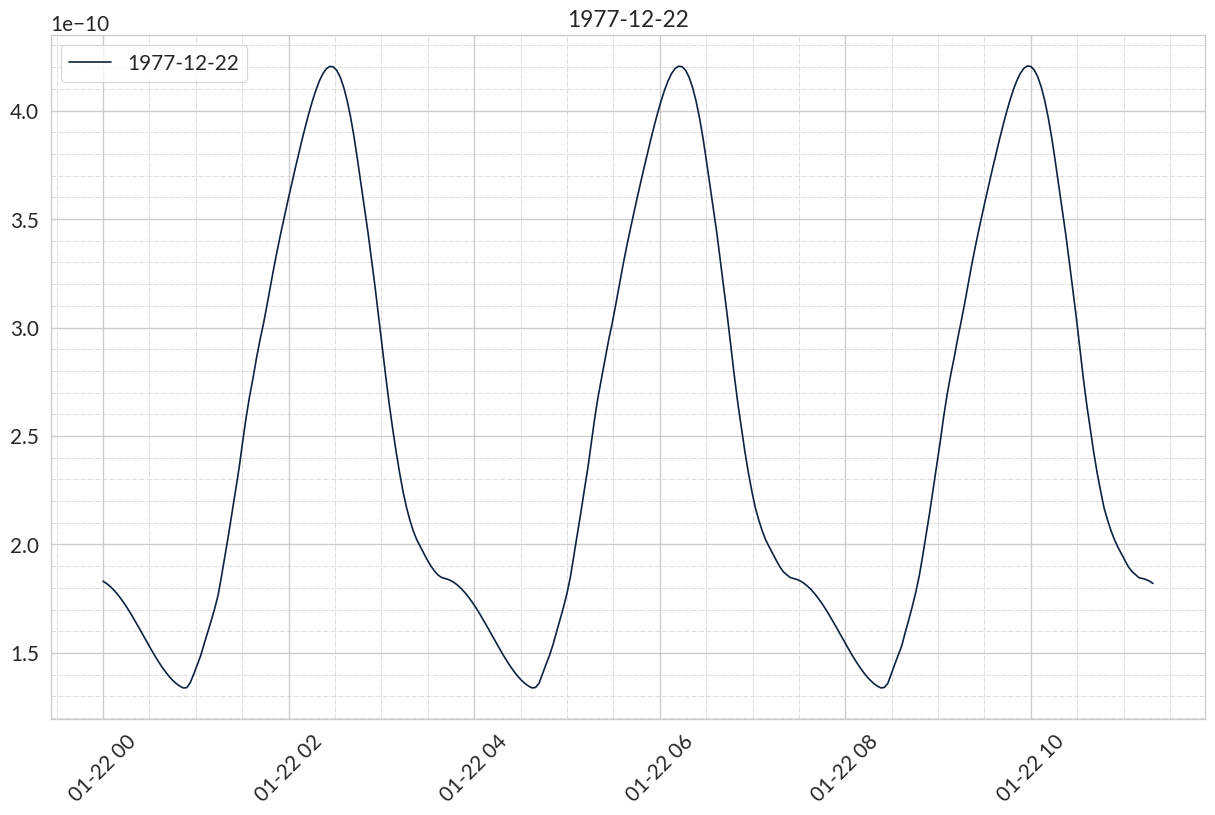

In [325]:
for date, df in dfs_year.items():
    plot_single([df], [date], "acc_rp_earth_radial", date)

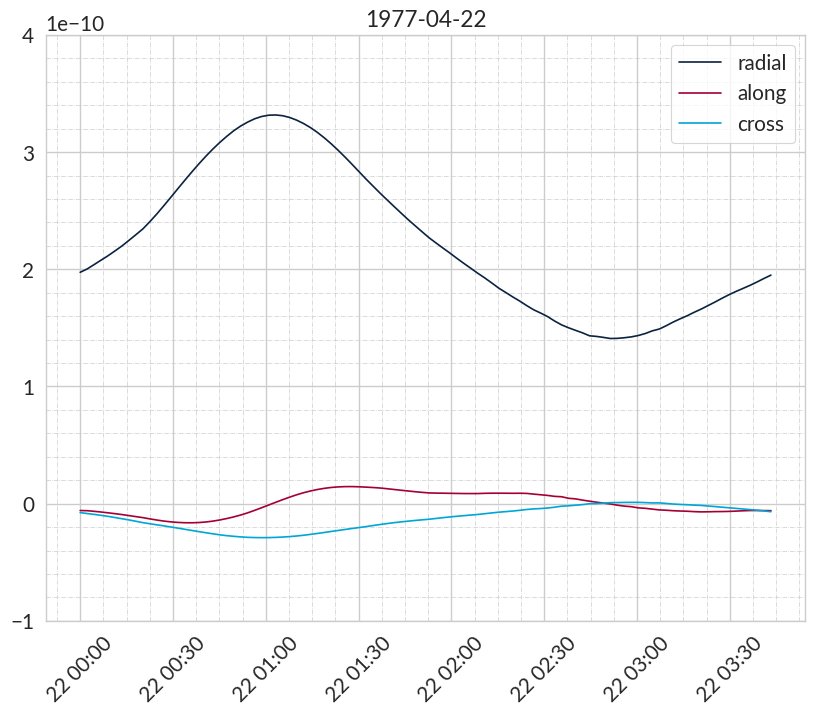

In [326]:
plot_accelerations_joint(dfs_year["1977-04-22"], "1977-04-22")#, ylim=[-1e-10, 3e-10])

In [327]:
(dfs_aprime["1977-04-22"]["acc_rp_earth"].max() - dfs_year["1977-04-22"]["acc_rp_earth"].max()) / dfs_aprime["1977-04-22"]["acc_rp_earth"].max() * 100

-2.120342578580526

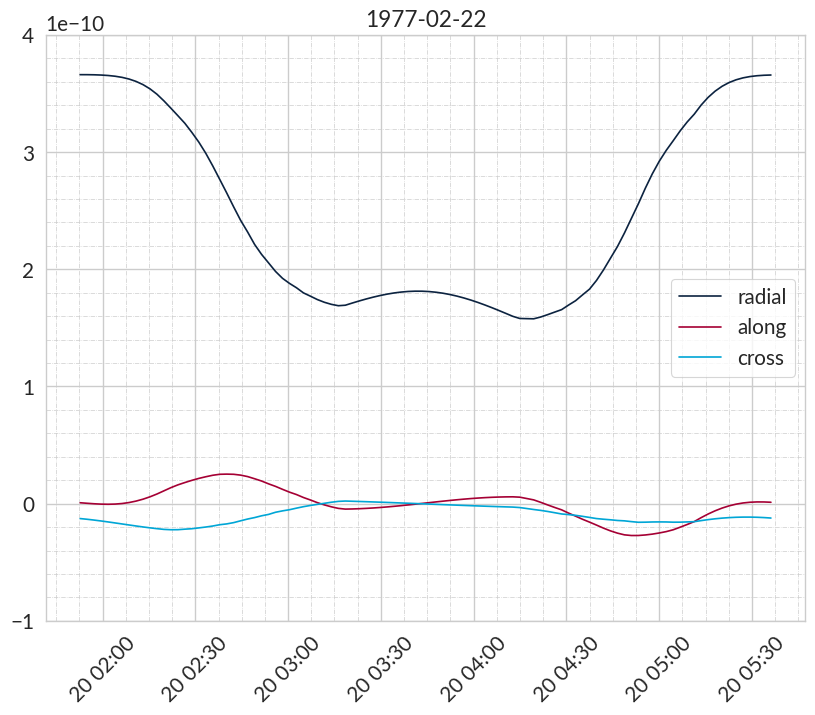

In [328]:
plot_accelerations_joint(dfs_0deg["1977-02-22"], "1977-02-22", idx_start=50)

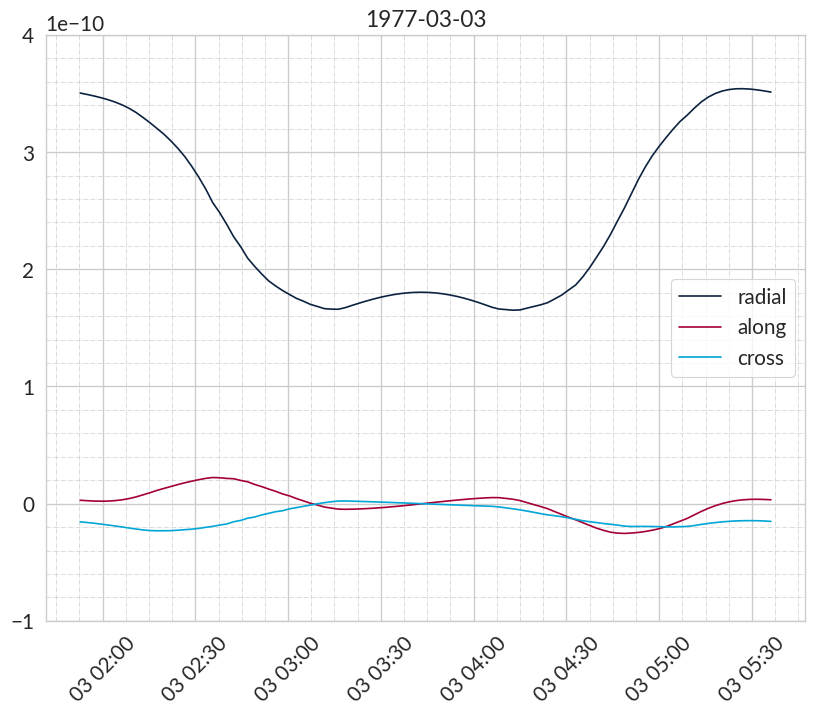

In [329]:
plot_accelerations_joint(dfs_0deg2["1977-03-03"], "1977-03-03", idx_start=50)

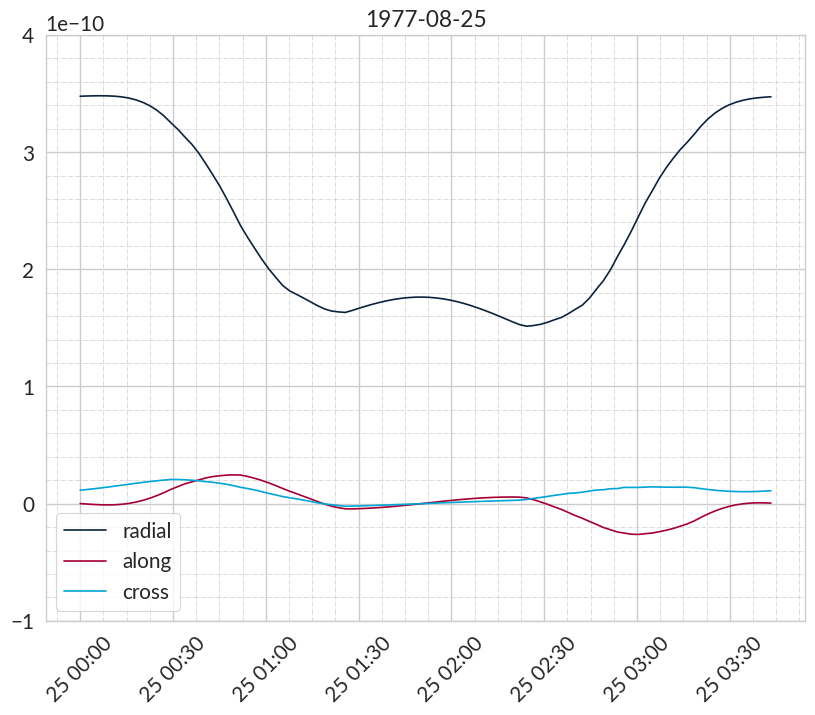

In [330]:
plot_accelerations_joint(dfs_0deg3["1977-08-25"], "1977-08-25", idx_start=0)

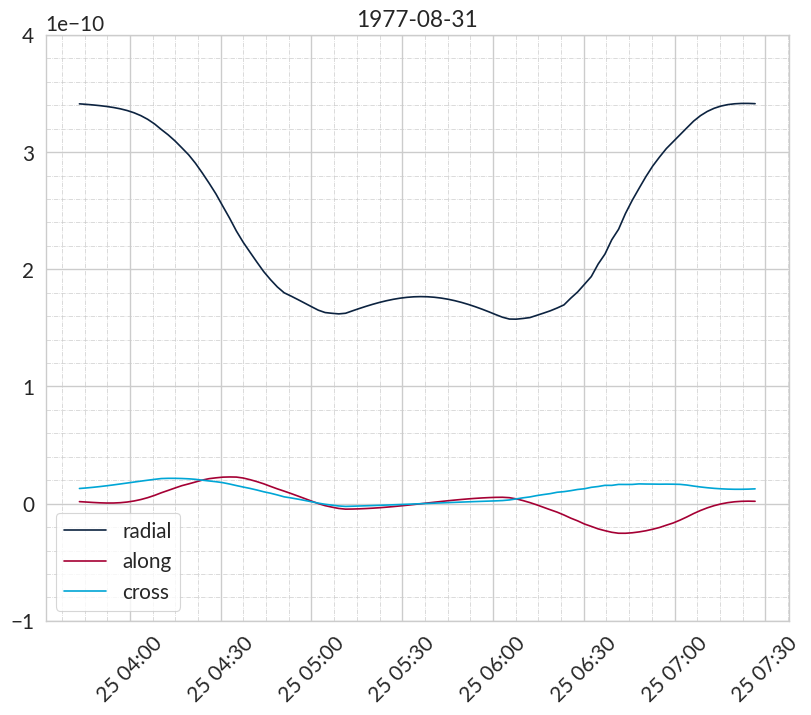

In [331]:
plot_accelerations_joint(dfs_0deg3["1977-08-31"], "1977-08-31", idx_start=99)